In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import itertools
import matplotlib.pyplot as plt 

from torch_geometric.data import Data
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import Linear

/home/devle/miniconda3/envs/277B_final_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load in data (GNPC supplementary table 5)
file_path = 'gnpc_supp.xlsx'
sheet_name = 'SuppTbl5'
df = pd.read_excel(file_path, sheet_name=sheet_name, header=1)

In [3]:
# select only the columns we need for training/prediction
col_for_training = ['EntrezGeneSymbol', 'Avg_StdBeta_weighted_AD', 'Meta_p_weighted_AD', 'Avg_StdBeta_weighted_PD', 'Meta_p_weighted_PD',
                    'Avg_StdBeta_weighted_FTD', 'Meta_p_weighted_FTD', 'StdBeta_ALS', 'p_ALS'] 

features_df = df[col_for_training].copy() # avoids SettingWithCopyWarning warning in next cell
features_df.rename(columns={'EntrezGeneSymbol' : 'EntrezGeneSymbol', 'Avg_StdBeta_weighted_AD' : 'AD_beta', 
                            'Meta_p_weighted_AD' : 'AD_p', 'Avg_StdBeta_weighted_PD' : 'PD_beta', 'Meta_p_weighted_PD' : 'PD_p',
                            'Avg_StdBeta_weighted_FTD' : 'FTD_beta', 'Meta_p_weighted_FTD' : 'FTD_p', 'StdBeta_ALS': 'ALS_beta', 'p_ALS' : 'ALS_p'
                            }, inplace=True)# rename cols for easier access  
features_df.head()

,EntrezGeneSymbol,AD_beta,AD_p,PD_beta,PD_p,FTD_beta,FTD_p,ALS_beta,ALS_p
0,CRYBB2,0.020411,0.105892,-0.019541,0.002026,0.016847,0.126806,-0.075116,0.201204
1,RAF1,-0.018095,0.863149,0.004977,0.189185,0.007533,0.393355,-0.052058,0.369734
2,ZNF41,0.049706,0.000772,0.004067,0.466674,0.000385,0.385409,0.015578,0.790375
3,ELK1,0.028990,0.002776,0.010033,0.580357,0.000471,0.457739,0.088028,0.129374
4,GUCA1A,-0.014837,0.151340,-0.006160,0.018256,-0.054077,0.095542,0.030428,0.603799


In [4]:
# data cleaning
# remove NAs & fill with zero, keep only the first duplicate for genes with multiple entries

print(f"Shape before: {features_df.shape}")
features_df.drop_duplicates(subset='EntrezGeneSymbol', keep='first', inplace=True)
features_df.set_index('EntrezGeneSymbol', inplace=True)
features_df.fillna(0, inplace=True)
print(f"Shape after: {features_df.shape}")

Shape before: (7289, 9)
Shape after: (6386, 8)


In [5]:
# feature engineering
# p values could really skew our overall data distribution, so we will -log transform them

# small value added to prevent log(0)
epsilon = 1e-8

# create the -log10(p-value) features
p_value_cols = ['AD_p', 'PD_p', 'FTD_p', 'ALS_p']
for col in p_value_cols:
    new_col_name = col.replace('_p', '_logp')
    features_df[new_col_name] = -np.log10(features_df[col] + epsilon)

# create feature matrix
final_features = [
    'AD_beta', 'AD_logp',
    'PD_beta', 'PD_logp',
    'FTD_beta', 'FTD_logp',
    'ALS_beta', 'ALS_p'
]

# filter out old p value cols
final_features_df = features_df[final_features]
final_features_df.head()

,AD_beta,AD_logp,PD_beta,PD_logp,FTD_beta,FTD_logp,ALS_beta,ALS_p
EntrezGeneSymbol,,,,,,,,
CRYBB2,0.020411,0.975136,-0.019541,2.693365,0.016847,0.896860,-0.075116,0.201204
RAF1,-0.018095,0.063914,0.004977,0.723114,0.007533,0.405216,-0.052058,0.369734
ZNF41,0.049706,3.112230,0.004067,0.330987,0.000385,0.414078,0.015578,0.790375
ELK1,0.028990,2.556574,0.010033,0.236305,0.000471,0.339382,0.088028,0.129374
GUCA1A,-0.014837,0.820047,-0.006160,1.738601,-0.054077,1.019804,0.030428,0.603799


In [6]:
# get the PPI graph edges to use for the edge_weights and edge_index tensors
edges = pd.read_csv("ppi_edges_raw.csv")

# get edge indices as np array
edge_indices_np = edges[['src', 'dst']].values

# transpose array so it's in correct format for torch_geometric (2 x num_edges)
edge_indices_transposed = edge_indices_np.transpose()

edges.head()

,src,dst,weight,combined_score
0,0,904,0.952953,952.0
1,0,1878,0.888889,888.0
2,0,4898,0.862863,862.0
3,0,1629,0.861862,861.0
4,0,5307,0.842843,842.0


In [7]:
# Generate torch_geometric.data.data Data object

scaler = StandardScaler() # we need to scale our beta values

# create X
X_scaled = scaler.fit_transform(final_features_df.values)
X = torch.tensor(X_scaled, dtype=torch.float)

# create Y - we're predicting beta values for all 4 diseases
y_df = features_df[['AD_beta', 'PD_beta', 'FTD_beta', 'ALS_beta']] 
y_scaled = scaler.fit_transform(y_df.values)
Y = torch.tensor(y_scaled, dtype=torch.float)

# create edge index tensor
edge_index = torch.tensor(edge_indices_transposed, dtype = torch.long)

# create edge weight tensor
edge_weights = torch.tensor(edges['weight'].values, dtype=torch.float)


# create training, validation, and testing masks (60/20/20 split)
N = final_features_df.shape[0]
split_labels = np.random.choice([0, 1, 2], N, p = [0.6, 0.2, 0.2]) # 0 is train, 1 is val, 2 is test

train_mask = torch.tensor(split_labels==0, dtype=torch.bool)
val_mask = torch.tensor(split_labels==1, dtype=torch.bool)
test_mask = torch.tensor(split_labels==2, dtype=torch.bool)

# create data object
graph_data = Data(
    x=X,
    edge_index=edge_index,
    edge_weights=edge_weights,
    y=Y,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
)
graph_data

Data(x=[6386, 8], edge_index=[2, 80102], y=[6386, 4], edge_weights=[80102], train_mask=[6386], val_mask=[6386], test_mask=[6386])

In [8]:
def get_loss_weights(df):
    '''
    Calculates weights for loss function terms based on inverse variance of beta values.

    Parameters
    ----------
    df : Pandas DataFrame that includes the columns "AD_beta", "PD_beta", "FTD_beta", "ALS_beta"

    Returns
    -------
    ad_wt, pd_wt, ftd_wt, als_wt : weights for each component of the combined loss function
    '''

    betas = df[["AD_beta", "PD_beta", "FTD_beta", "ALS_beta"]]

    # get variance of beta values for each disease 
    variances_by_disease = betas.var()

    # calculate inverse variance to use as weight
    inverse_variances = 1/variances_by_disease.values

    # normalize weights so they add up to 1
    normalized_wts = inverse_variances / inverse_variances.sum()

    ad_wt, pd_wt, ftd_wt, als_wt = normalized_wts

    return ad_wt, pd_wt, ftd_wt, als_wt

AD_wt = get_loss_weights(final_features_df)[0]
PD_wt = get_loss_weights(final_features_df)[1]
FTD_wt = get_loss_weights(final_features_df)[2]
ALS_wt = get_loss_weights(final_features_df)[3]

Epoch 000 | Train: 0.9869 | Val: 0.9885 * NEW BEST
Epoch 010 | Train: 0.8970 | Val: 0.8878 * NEW BEST
Epoch 020 | Train: 0.8069 | Val: 0.7893 * NEW BEST
Epoch 030 | Train: 0.7430 | Val: 0.7333 * NEW BEST
Epoch 040 | Train: 0.7104 | Val: 0.6949 * NEW BEST
Epoch 050 | Train: 0.6884 | Val: 0.6732 * NEW BEST
Epoch 060 | Train: 0.6770 | Val: 0.6640 * NEW BEST
Epoch 070 | Train: 0.6667 | Val: 0.6578 * NEW BEST
Epoch 080 | Train: 0.6612 | Val: 0.6527 * NEW BEST
Epoch 090 | Train: 0.6551 | Val: 0.6482 * NEW BEST
Epoch 100 | Train: 0.6560 | Val: 0.6442 * NEW BEST
Epoch 110 | Train: 0.6455 | Val: 0.6400 * NEW BEST
Epoch 120 | Train: 0.6441 | Val: 0.6373 * NEW BEST
Epoch 130 | Train: 0.6415 | Val: 0.6344 * NEW BEST
Epoch 140 | Train: 0.6367 | Val: 0.6315 * NEW BEST
Epoch 150 | Train: 0.6343 | Val: 0.6287 * NEW BEST
Epoch 160 | Train: 0.6301 | Val: 0.6258 * NEW BEST
Epoch 170 | Train: 0.6255 | Val: 0.6237 * NEW BEST
Epoch 180 | Train: 0.6230 | Val: 0.6208 * NEW BEST
Epoch 190 | Train: 0.6224 | Val

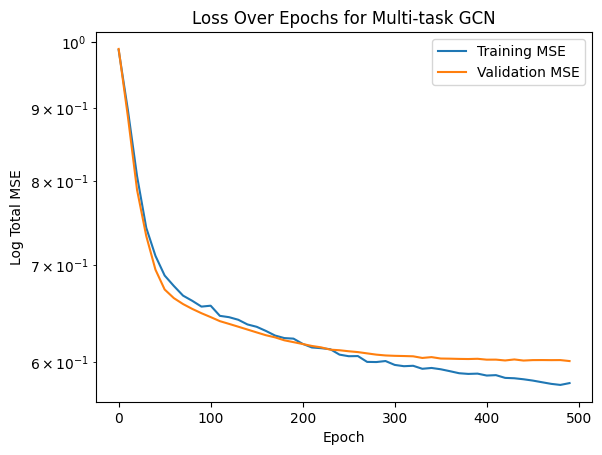

(0.5770879983901978, tensor(0.6005, device='cuda:0'))

In [11]:
# model - 2 layer GCN  with 4 outputs (regression for beta prediction for each disease)
class My_GCN(torch.nn.Module):
    
    def __init__(self, num_features, n_neurons, dropout):
        '''
        Initializes an instances of the My_GCN class.

        Parameters
        ----------
        num_features : int
            Number of features in the feature tensor (X).
        n_neurons : int
            Number of dimensions in the space that input features are transformed to.
        dropout : float
            Percentage that determines how many neurons are ignored during a foward/backward pass.

        '''
        super(My_GCN, self).__init__()
        
        self.dropout = dropout

        self.conv1 = GCNConv(num_features, n_neurons)
        self.conv2 = GCNConv(n_neurons, n_neurons)

        # linear layers for beta prediction for each disease
        self.out_ad = Linear(n_neurons, 1) 
        self.out_pd = Linear(n_neurons, 1) 
        self.out_ftd = Linear(n_neurons, 1)  
        self.out_als = Linear(n_neurons, 1) 

    def forward(self, data):
        '''
        Forward pass for the 2-layer GCN. 

        Parameters
        ----------
        data : Pandas DataFrame
            Includes beta values and p-values for each disease.

        Returns
        -------
        AD_pred, PD_pred, FTD_pred, ALS_pred : Pytorch tensors
            Beta predictions for each disease.
        '''        
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weights

        x1 = self.conv1(x, edge_index, edge_weight)
        x2 = F.relu(x1)
        x3 = F.dropout(x2, p=self.dropout, training=self.training)

        x4 = self.conv2(x3, edge_index, edge_weight)
        x5 = F.relu(x4)

        # get predictions for each disease, removing dimension of 1
        AD_pred = self.out_ad(x5).squeeze(1)
        PD_pred = self.out_pd(x5).squeeze(1)
        FTD_pred = self.out_ftd(x5).squeeze(1)
        ALS_pred = self.out_als(x5).squeeze(1)
        
        return AD_pred, PD_pred, FTD_pred, ALS_pred

class FitModel():
    
    def __init__(self, my_model, learning_rate: float = 0.01):
        
        # Adam for optimization
        self.optimizer = torch.optim.Adam(my_model.parameters(), lr = learning_rate)
        self.model = my_model

    def get_MSE(self, data, mask):
        ''' 
        Calculates MSE for each disease beta prediction.
        
        Parameters
        ----------
        data : Pandas DataFrame
            Includes beta values and p-values for each disease.

        mask : NumPy array
            Proteins (nodes) used for either training, validation, or testing.

        Returns
        -------
        MSE_ad, MSE_pd, MSE_ftd, MSE_als : float
            MSE values for each disease beta prediction.
        '''

        out1, out2, out3, out4 = self.model(data)

        # calculate MSE for each disease beta prediction
        MSE_ad = F.mse_loss(out1[mask], data.y[mask, 0])
        MSE_pd = F.mse_loss(out2[mask], data.y[mask, 1])
        MSE_ftd = F.mse_loss(out3[mask], data.y[mask, 2])
        MSE_als = F.mse_loss(out4[mask], data.y[mask, 3])

        return MSE_ad, MSE_pd, MSE_ftd, MSE_als
        
    def run(self, data, N_epochs: int = 500):
        '''
        Runs the training loop, validation, and testing on the best model identified by validation loss.

        Parameters
        ----------
        data : Pandas DataFrame
            Includes beta values and p-values for each disease.

        N_epochs : int
            Number of times to run the training loop. 

        Returns
        -------
        total_loss : float
            Total loss for the final epoch.
        best_val_loss : float
            Best validation loss found over N_epochs.
        '''
        best_val_loss = float('inf')

        # intialize lists so we can plot MSE over epochs
        train_losses = []
        val_losses = []
        epoch_nums = []
        
        for n in range(N_epochs):
            
            self.model.train() # set model to training mode (learning is occurring)
            self.optimizer.zero_grad()
            
            # get MSE for each disease
            ad_loss, pd_loss, ftd_loss, als_loss = self.get_MSE(data, data.train_mask)

            total_loss = AD_wt*ad_loss + PD_wt*pd_loss + FTD_wt*ftd_loss + ALS_wt*als_loss
            total_loss.backward()
            
            self.optimizer.step()

            if n % 10 == 0:
                # validation loss
                self.model.eval() # pause learning
                with torch.no_grad():
                    ad_MSE_val, pd_MSE_val, ftd_MSE_val, als_MSE_val = self.get_MSE(data, data.val_mask)
                    total_val_loss = AD_wt*ad_MSE_val + PD_wt*pd_MSE_val + FTD_wt*ftd_MSE_val + ALS_wt*als_MSE_val

                    # add losses & current epoch to lists
                    train_losses.append(total_loss.item())
                    val_losses.append(total_val_loss.item())
                    epoch_nums.append(n)
                
                # compare current loss to best loss
                if total_val_loss.item() < best_val_loss:
                    best_val_loss = total_val_loss

                    # save best model
                    torch.save(self.model.state_dict(), 'best_model.pt')

                    print(f"Epoch {n:03d} | Train: {total_loss.item():.4f} | Val: {total_val_loss.item():.4f} * NEW BEST")
                else:
                    print(f"Epoch {n:03d} | Train: {total_loss.item():.4f} | Val: {total_val_loss.item():.4f}")

        # testing loss
        # get best model
        self.model.load_state_dict(torch.load('best_model.pt'))

        self.model.eval()
        with torch.no_grad():
            ad_MSE_test, pd_MSE_test, ftd_MSE_test, als_MSE_test = self.get_MSE(data, data.test_mask)
            total_test_loss = AD_wt*ad_MSE_test + PD_wt*pd_MSE_test + FTD_wt*ftd_MSE_test + ALS_wt*als_MSE_test

        print(f"Best val loss: {best_val_loss}")   
        print(f"Test loss for best model: {total_test_loss}")

        # plot train and val mse over epochs
        self.plot(train_losses, val_losses, epoch_nums)

        return total_loss.item(), best_val_loss
    
    def hp_tuning(self, data, num_features):
        '''Performs hyperparameter tuning for the GCN by iterating through combinations of learning rate, number of neurons, and dropout rate.
        
        Parameters
        ----------
        data : Pandas DataFrame
            Includes beta values and p-values for each disease.

        num_features : int
            Number of features in the feature tensor (X).

        Returns
        -------
        best_params : dictonary
            Combination of parameters that produced the lowest validation loss.
        '''

        # define parameter space (learning rate, dropout rate, n_neurons)

        param_grid = {
            'learning_rate' : [0.001, 0.0005, 0.001, 0.00005, 0.00001], 
            'n_neurons' : [32, 64, 128],
            'dropout_rate' : [0.1, 0.3, 0.5, 0.7]
            }

        best_loss = float('inf') # initialize with value of +infinity
        best_params = None

        for lr, n_neurons, dr in itertools.product(param_grid['learning_rate'], param_grid['n_neurons'], param_grid['dropout_rate']):

            model = My_GCN(num_features=num_features, n_neurons=n_neurons, dropout=dr)
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = model.to(device)

            hp_tuner = FitModel(model, learning_rate=lr)
            losses = hp_tuner.run(data, N_epochs=500)
            current_loss_t = losses[1]
            current_loss = current_loss_t.item()

            if current_loss < best_loss:
                best_loss = current_loss
                best_params = {'lr' : lr, 'n_neurons' : n_neurons, 'dr' : dr}
        print(f'Best params: {best_params}')
        print(f'Best val loss: {best_loss}')

        return best_params
    
    def plot(self, train_losses, val_losses, epoch_nums):
        '''
        Plots MSE loss over epochs for training and validation.

        Parameters
        ----------
        train_losses : list
            List containing training losses for all epochs.
        val_losses : list
            List containing validation losses for all epochs.
        epoch_nums : list
            List containing epoch numbers. 
        '''

        plt.figure()
        plt.plot(epoch_nums, train_losses, label = 'Training MSE')
        plt.plot(epoch_nums, val_losses, label = 'Validation MSE')

        plt.title("Loss Over Epochs for Multi-task GCN")
        plt.xlabel("Epoch")
        plt.ylabel("Log Total MSE")
        plt.yscale("log")
        plt.legend()
        plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_model = My_GCN(num_features=X.shape[1], n_neurons=128, dropout=0.5) # parameters determined through hyperparameter search
my_model = my_model.to(device)
graph_data = graph_data.to(device)
My_Fit = FitModel(my_model, 0.001)
My_Fit.run(graph_data)

Epoch 000 | Train: 0.9976 | Val: 1.0138 * NEW BEST
Epoch 010 | Train: 0.9710 | Val: 0.9833 * NEW BEST
Epoch 020 | Train: 0.9463 | Val: 0.9539 * NEW BEST
Epoch 030 | Train: 0.9154 | Val: 0.9197 * NEW BEST
Epoch 040 | Train: 0.8792 | Val: 0.8786 * NEW BEST
Epoch 050 | Train: 0.8372 | Val: 0.8335 * NEW BEST
Epoch 060 | Train: 0.7941 | Val: 0.7914 * NEW BEST
Epoch 070 | Train: 0.7613 | Val: 0.7601 * NEW BEST
Epoch 080 | Train: 0.7357 | Val: 0.7384 * NEW BEST
Epoch 090 | Train: 0.7174 | Val: 0.7189 * NEW BEST
Epoch 100 | Train: 0.7008 | Val: 0.7017 * NEW BEST
Epoch 110 | Train: 0.6891 | Val: 0.6887 * NEW BEST
Epoch 120 | Train: 0.6812 | Val: 0.6790 * NEW BEST
Epoch 130 | Train: 0.6716 | Val: 0.6718 * NEW BEST
Epoch 140 | Train: 0.6659 | Val: 0.6662 * NEW BEST
Epoch 150 | Train: 0.6595 | Val: 0.6618 * NEW BEST
Epoch 160 | Train: 0.6580 | Val: 0.6580 * NEW BEST
Epoch 170 | Train: 0.6553 | Val: 0.6551 * NEW BEST
Epoch 180 | Train: 0.6515 | Val: 0.6527 * NEW BEST
Epoch 190 | Train: 0.6482 | Val

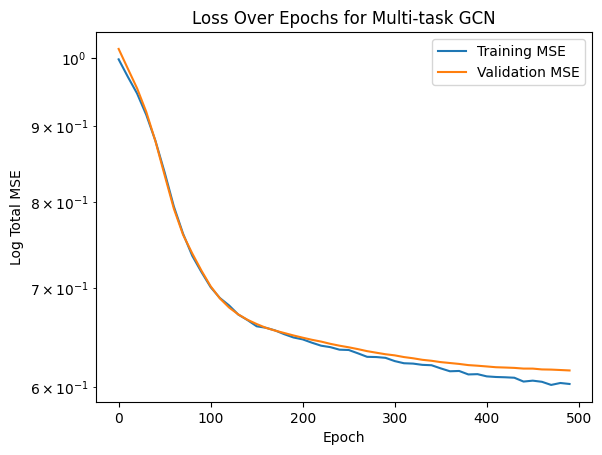

Epoch 000 | Train: 1.0234 | Val: 1.0336 * NEW BEST
Epoch 010 | Train: 0.9954 | Val: 1.0050 * NEW BEST
Epoch 020 | Train: 0.9726 | Val: 0.9801 * NEW BEST
Epoch 030 | Train: 0.9498 | Val: 0.9541 * NEW BEST
Epoch 040 | Train: 0.9230 | Val: 0.9232 * NEW BEST
Epoch 050 | Train: 0.8855 | Val: 0.8857 * NEW BEST
Epoch 060 | Train: 0.8514 | Val: 0.8433 * NEW BEST
Epoch 070 | Train: 0.8142 | Val: 0.8014 * NEW BEST
Epoch 080 | Train: 0.7763 | Val: 0.7660 * NEW BEST
Epoch 090 | Train: 0.7518 | Val: 0.7402 * NEW BEST
Epoch 100 | Train: 0.7315 | Val: 0.7207 * NEW BEST
Epoch 110 | Train: 0.7166 | Val: 0.7043 * NEW BEST
Epoch 120 | Train: 0.7071 | Val: 0.6903 * NEW BEST
Epoch 130 | Train: 0.6989 | Val: 0.6793 * NEW BEST
Epoch 140 | Train: 0.6910 | Val: 0.6711 * NEW BEST
Epoch 150 | Train: 0.6806 | Val: 0.6646 * NEW BEST
Epoch 160 | Train: 0.6785 | Val: 0.6598 * NEW BEST
Epoch 170 | Train: 0.6744 | Val: 0.6567 * NEW BEST
Epoch 180 | Train: 0.6733 | Val: 0.6543 * NEW BEST
Epoch 190 | Train: 0.6678 | Val

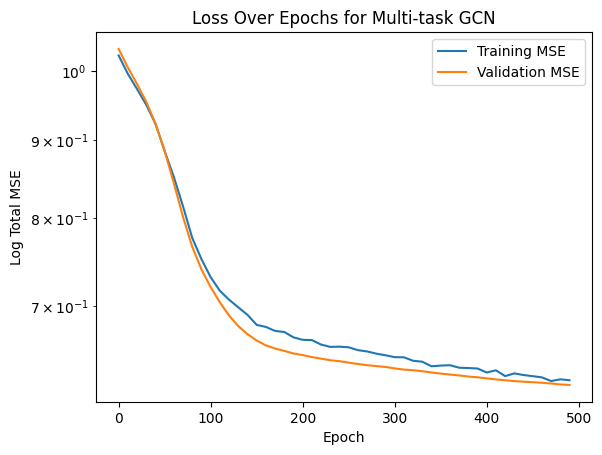

Epoch 000 | Train: 1.0344 | Val: 1.0412 * NEW BEST
Epoch 010 | Train: 0.9990 | Val: 1.0077 * NEW BEST
Epoch 020 | Train: 0.9705 | Val: 0.9787 * NEW BEST
Epoch 030 | Train: 0.9444 | Val: 0.9480 * NEW BEST
Epoch 040 | Train: 0.9146 | Val: 0.9120 * NEW BEST
Epoch 050 | Train: 0.8825 | Val: 0.8710 * NEW BEST
Epoch 060 | Train: 0.8404 | Val: 0.8295 * NEW BEST
Epoch 070 | Train: 0.8124 | Val: 0.7934 * NEW BEST
Epoch 080 | Train: 0.7969 | Val: 0.7671 * NEW BEST
Epoch 090 | Train: 0.7802 | Val: 0.7482 * NEW BEST
Epoch 100 | Train: 0.7557 | Val: 0.7327 * NEW BEST
Epoch 110 | Train: 0.7524 | Val: 0.7194 * NEW BEST
Epoch 120 | Train: 0.7355 | Val: 0.7080 * NEW BEST
Epoch 130 | Train: 0.7296 | Val: 0.6979 * NEW BEST
Epoch 140 | Train: 0.7257 | Val: 0.6891 * NEW BEST
Epoch 150 | Train: 0.7200 | Val: 0.6818 * NEW BEST
Epoch 160 | Train: 0.7150 | Val: 0.6758 * NEW BEST
Epoch 170 | Train: 0.7071 | Val: 0.6709 * NEW BEST
Epoch 180 | Train: 0.7041 | Val: 0.6666 * NEW BEST
Epoch 190 | Train: 0.7017 | Val

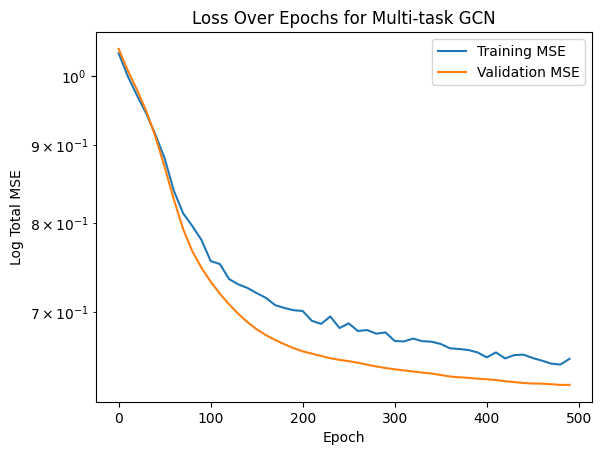

Epoch 000 | Train: 1.0104 | Val: 1.0192 * NEW BEST
Epoch 010 | Train: 0.9860 | Val: 0.9863 * NEW BEST
Epoch 020 | Train: 0.9616 | Val: 0.9573 * NEW BEST
Epoch 030 | Train: 0.9318 | Val: 0.9285 * NEW BEST
Epoch 040 | Train: 0.9106 | Val: 0.8980 * NEW BEST
Epoch 050 | Train: 0.8823 | Val: 0.8661 * NEW BEST
Epoch 060 | Train: 0.8581 | Val: 0.8355 * NEW BEST
Epoch 070 | Train: 0.8423 | Val: 0.8085 * NEW BEST
Epoch 080 | Train: 0.8239 | Val: 0.7860 * NEW BEST
Epoch 090 | Train: 0.8128 | Val: 0.7675 * NEW BEST
Epoch 100 | Train: 0.7973 | Val: 0.7512 * NEW BEST
Epoch 110 | Train: 0.7880 | Val: 0.7368 * NEW BEST
Epoch 120 | Train: 0.7836 | Val: 0.7242 * NEW BEST
Epoch 130 | Train: 0.7770 | Val: 0.7143 * NEW BEST
Epoch 140 | Train: 0.7705 | Val: 0.7059 * NEW BEST
Epoch 150 | Train: 0.7601 | Val: 0.6992 * NEW BEST
Epoch 160 | Train: 0.7542 | Val: 0.6935 * NEW BEST
Epoch 170 | Train: 0.7538 | Val: 0.6887 * NEW BEST
Epoch 180 | Train: 0.7502 | Val: 0.6848 * NEW BEST
Epoch 190 | Train: 0.7439 | Val

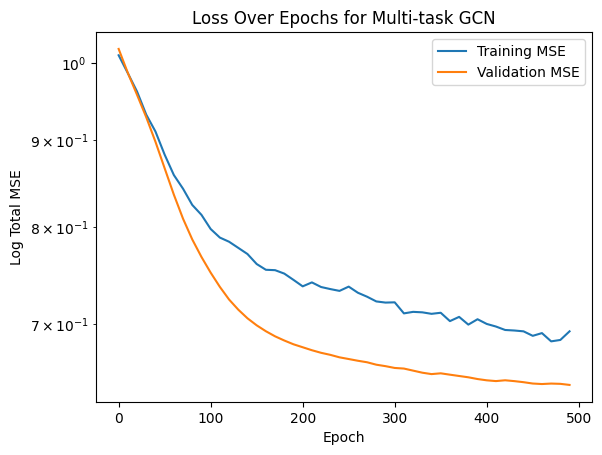

Epoch 000 | Train: 0.9860 | Val: 0.9996 * NEW BEST
Epoch 010 | Train: 0.9335 | Val: 0.9421 * NEW BEST
Epoch 020 | Train: 0.8789 | Val: 0.8833 * NEW BEST
Epoch 030 | Train: 0.8234 | Val: 0.8264 * NEW BEST
Epoch 040 | Train: 0.7758 | Val: 0.7808 * NEW BEST
Epoch 050 | Train: 0.7387 | Val: 0.7481 * NEW BEST
Epoch 060 | Train: 0.7112 | Val: 0.7179 * NEW BEST
Epoch 070 | Train: 0.6880 | Val: 0.6922 * NEW BEST
Epoch 080 | Train: 0.6690 | Val: 0.6746 * NEW BEST
Epoch 090 | Train: 0.6605 | Val: 0.6644 * NEW BEST
Epoch 100 | Train: 0.6556 | Val: 0.6584 * NEW BEST
Epoch 110 | Train: 0.6494 | Val: 0.6546 * NEW BEST
Epoch 120 | Train: 0.6449 | Val: 0.6510 * NEW BEST
Epoch 130 | Train: 0.6399 | Val: 0.6474 * NEW BEST
Epoch 140 | Train: 0.6378 | Val: 0.6443 * NEW BEST
Epoch 150 | Train: 0.6343 | Val: 0.6410 * NEW BEST
Epoch 160 | Train: 0.6297 | Val: 0.6383 * NEW BEST
Epoch 170 | Train: 0.6261 | Val: 0.6351 * NEW BEST
Epoch 180 | Train: 0.6224 | Val: 0.6323 * NEW BEST
Epoch 190 | Train: 0.6194 | Val

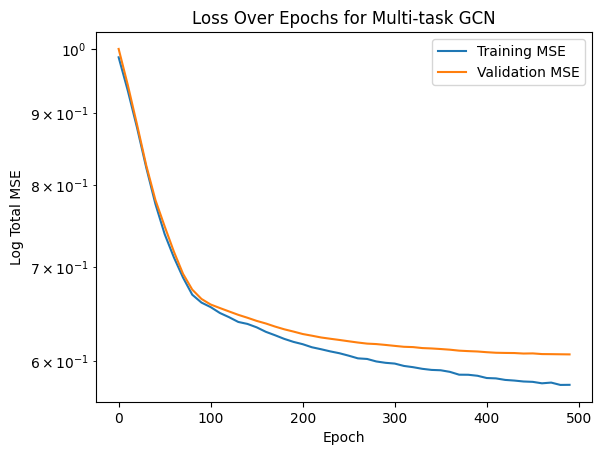

Epoch 000 | Train: 1.0031 | Val: 1.0084 * NEW BEST
Epoch 010 | Train: 0.9570 | Val: 0.9586 * NEW BEST
Epoch 020 | Train: 0.9066 | Val: 0.9048 * NEW BEST
Epoch 030 | Train: 0.8472 | Val: 0.8417 * NEW BEST
Epoch 040 | Train: 0.7911 | Val: 0.7832 * NEW BEST
Epoch 050 | Train: 0.7458 | Val: 0.7447 * NEW BEST
Epoch 060 | Train: 0.7169 | Val: 0.7145 * NEW BEST
Epoch 070 | Train: 0.6977 | Val: 0.6908 * NEW BEST
Epoch 080 | Train: 0.6855 | Val: 0.6754 * NEW BEST
Epoch 090 | Train: 0.6740 | Val: 0.6662 * NEW BEST
Epoch 100 | Train: 0.6683 | Val: 0.6598 * NEW BEST
Epoch 110 | Train: 0.6624 | Val: 0.6558 * NEW BEST
Epoch 120 | Train: 0.6581 | Val: 0.6516 * NEW BEST
Epoch 130 | Train: 0.6535 | Val: 0.6484 * NEW BEST
Epoch 140 | Train: 0.6501 | Val: 0.6460 * NEW BEST
Epoch 150 | Train: 0.6452 | Val: 0.6436 * NEW BEST
Epoch 160 | Train: 0.6421 | Val: 0.6407 * NEW BEST
Epoch 170 | Train: 0.6412 | Val: 0.6385 * NEW BEST
Epoch 180 | Train: 0.6372 | Val: 0.6362 * NEW BEST
Epoch 190 | Train: 0.6362 | Val

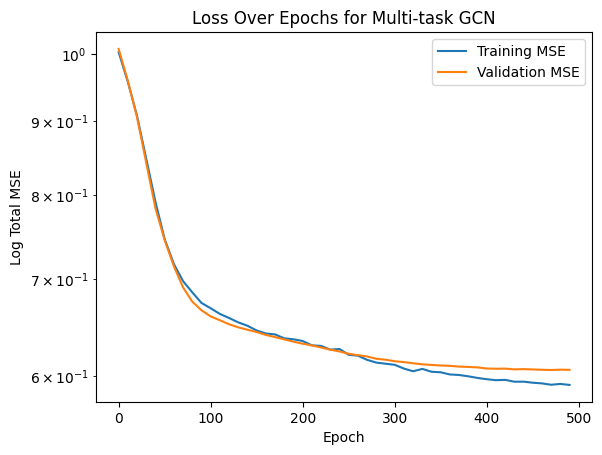

Epoch 000 | Train: 1.0067 | Val: 1.0175 * NEW BEST
Epoch 010 | Train: 0.9607 | Val: 0.9639 * NEW BEST
Epoch 020 | Train: 0.9133 | Val: 0.9089 * NEW BEST
Epoch 030 | Train: 0.8603 | Val: 0.8464 * NEW BEST
Epoch 040 | Train: 0.8043 | Val: 0.7862 * NEW BEST
Epoch 050 | Train: 0.7627 | Val: 0.7464 * NEW BEST
Epoch 060 | Train: 0.7379 | Val: 0.7192 * NEW BEST
Epoch 070 | Train: 0.7175 | Val: 0.6949 * NEW BEST
Epoch 080 | Train: 0.7066 | Val: 0.6798 * NEW BEST
Epoch 090 | Train: 0.6969 | Val: 0.6704 * NEW BEST
Epoch 100 | Train: 0.6884 | Val: 0.6638 * NEW BEST
Epoch 110 | Train: 0.6854 | Val: 0.6591 * NEW BEST
Epoch 120 | Train: 0.6780 | Val: 0.6553 * NEW BEST
Epoch 130 | Train: 0.6713 | Val: 0.6519 * NEW BEST
Epoch 140 | Train: 0.6686 | Val: 0.6495 * NEW BEST
Epoch 150 | Train: 0.6673 | Val: 0.6473 * NEW BEST
Epoch 160 | Train: 0.6660 | Val: 0.6446 * NEW BEST
Epoch 170 | Train: 0.6624 | Val: 0.6423 * NEW BEST
Epoch 180 | Train: 0.6591 | Val: 0.6400 * NEW BEST
Epoch 190 | Train: 0.6527 | Val

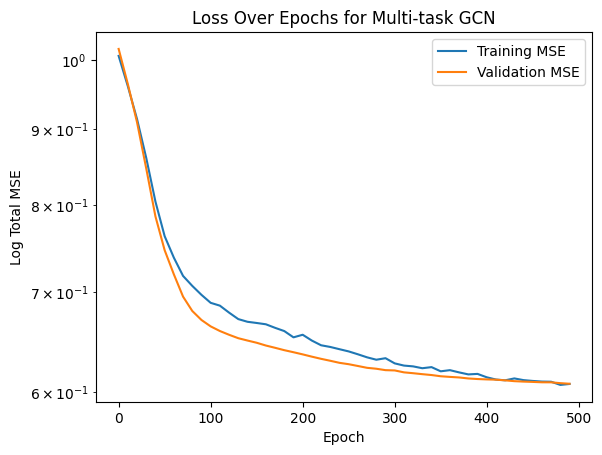

Epoch 000 | Train: 0.9967 | Val: 1.0010 * NEW BEST
Epoch 010 | Train: 0.9588 | Val: 0.9575 * NEW BEST
Epoch 020 | Train: 0.9241 | Val: 0.9121 * NEW BEST
Epoch 030 | Train: 0.8786 | Val: 0.8608 * NEW BEST
Epoch 040 | Train: 0.8387 | Val: 0.8095 * NEW BEST
Epoch 050 | Train: 0.8024 | Val: 0.7666 * NEW BEST
Epoch 060 | Train: 0.7722 | Val: 0.7356 * NEW BEST
Epoch 070 | Train: 0.7567 | Val: 0.7115 * NEW BEST
Epoch 080 | Train: 0.7447 | Val: 0.6941 * NEW BEST
Epoch 090 | Train: 0.7318 | Val: 0.6821 * NEW BEST
Epoch 100 | Train: 0.7250 | Val: 0.6744 * NEW BEST
Epoch 110 | Train: 0.7168 | Val: 0.6686 * NEW BEST
Epoch 120 | Train: 0.7045 | Val: 0.6638 * NEW BEST
Epoch 130 | Train: 0.7013 | Val: 0.6590 * NEW BEST
Epoch 140 | Train: 0.7039 | Val: 0.6557 * NEW BEST
Epoch 150 | Train: 0.6943 | Val: 0.6526 * NEW BEST
Epoch 160 | Train: 0.6867 | Val: 0.6500 * NEW BEST
Epoch 170 | Train: 0.6906 | Val: 0.6474 * NEW BEST
Epoch 180 | Train: 0.6820 | Val: 0.6452 * NEW BEST
Epoch 190 | Train: 0.6810 | Val

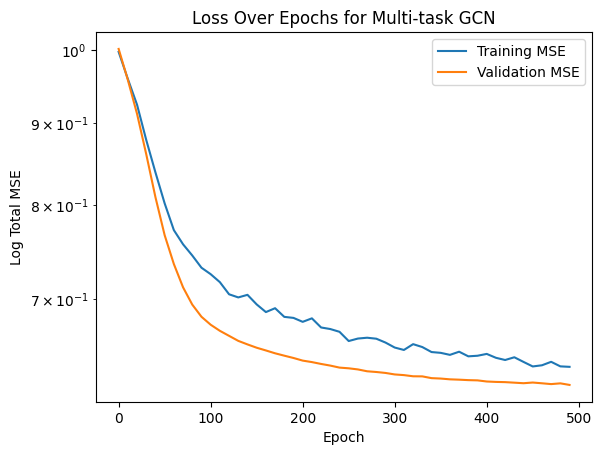

Epoch 000 | Train: 0.9956 | Val: 1.0009 * NEW BEST
Epoch 010 | Train: 0.9066 | Val: 0.9012 * NEW BEST
Epoch 020 | Train: 0.8067 | Val: 0.7945 * NEW BEST
Epoch 030 | Train: 0.7292 | Val: 0.7294 * NEW BEST
Epoch 040 | Train: 0.6908 | Val: 0.6984 * NEW BEST
Epoch 050 | Train: 0.6689 | Val: 0.6747 * NEW BEST
Epoch 060 | Train: 0.6570 | Val: 0.6648 * NEW BEST
Epoch 070 | Train: 0.6488 | Val: 0.6577 * NEW BEST
Epoch 080 | Train: 0.6427 | Val: 0.6528 * NEW BEST
Epoch 090 | Train: 0.6372 | Val: 0.6475 * NEW BEST
Epoch 100 | Train: 0.6340 | Val: 0.6433 * NEW BEST
Epoch 110 | Train: 0.6274 | Val: 0.6392 * NEW BEST
Epoch 120 | Train: 0.6231 | Val: 0.6353 * NEW BEST
Epoch 130 | Train: 0.6193 | Val: 0.6318 * NEW BEST
Epoch 140 | Train: 0.6145 | Val: 0.6280 * NEW BEST
Epoch 150 | Train: 0.6097 | Val: 0.6252 * NEW BEST
Epoch 160 | Train: 0.6079 | Val: 0.6220 * NEW BEST
Epoch 170 | Train: 0.6033 | Val: 0.6191 * NEW BEST
Epoch 180 | Train: 0.6010 | Val: 0.6172 * NEW BEST
Epoch 190 | Train: 0.5978 | Val

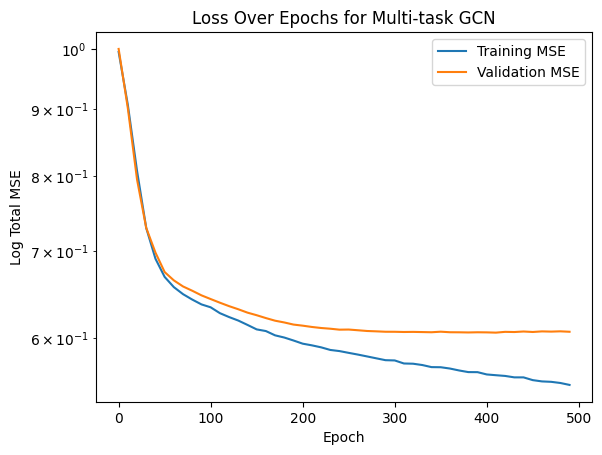

Epoch 000 | Train: 1.0017 | Val: 1.0044 * NEW BEST
Epoch 010 | Train: 0.9141 | Val: 0.9103 * NEW BEST
Epoch 020 | Train: 0.8156 | Val: 0.8022 * NEW BEST
Epoch 030 | Train: 0.7349 | Val: 0.7335 * NEW BEST
Epoch 040 | Train: 0.7001 | Val: 0.7016 * NEW BEST
Epoch 050 | Train: 0.6781 | Val: 0.6758 * NEW BEST
Epoch 060 | Train: 0.6688 | Val: 0.6651 * NEW BEST
Epoch 070 | Train: 0.6579 | Val: 0.6592 * NEW BEST
Epoch 080 | Train: 0.6535 | Val: 0.6537 * NEW BEST
Epoch 090 | Train: 0.6468 | Val: 0.6497 * NEW BEST
Epoch 100 | Train: 0.6425 | Val: 0.6458 * NEW BEST
Epoch 110 | Train: 0.6384 | Val: 0.6423 * NEW BEST
Epoch 120 | Train: 0.6353 | Val: 0.6390 * NEW BEST
Epoch 130 | Train: 0.6296 | Val: 0.6358 * NEW BEST
Epoch 140 | Train: 0.6264 | Val: 0.6326 * NEW BEST
Epoch 150 | Train: 0.6196 | Val: 0.6290 * NEW BEST
Epoch 160 | Train: 0.6174 | Val: 0.6263 * NEW BEST
Epoch 170 | Train: 0.6143 | Val: 0.6235 * NEW BEST
Epoch 180 | Train: 0.6102 | Val: 0.6210 * NEW BEST
Epoch 190 | Train: 0.6093 | Val

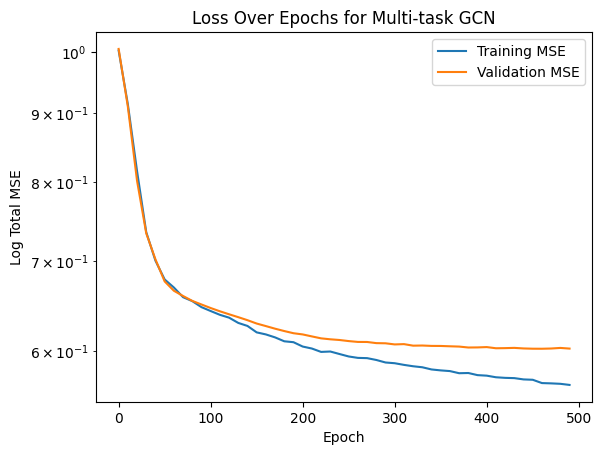

Epoch 000 | Train: 0.9948 | Val: 1.0019 * NEW BEST
Epoch 010 | Train: 0.9094 | Val: 0.9042 * NEW BEST
Epoch 020 | Train: 0.8166 | Val: 0.8067 * NEW BEST
Epoch 030 | Train: 0.7507 | Val: 0.7537 * NEW BEST
Epoch 040 | Train: 0.7109 | Val: 0.7053 * NEW BEST
Epoch 050 | Train: 0.6825 | Val: 0.6748 * NEW BEST
Epoch 060 | Train: 0.6771 | Val: 0.6652 * NEW BEST
Epoch 070 | Train: 0.6688 | Val: 0.6574 * NEW BEST
Epoch 080 | Train: 0.6621 | Val: 0.6536 * NEW BEST
Epoch 090 | Train: 0.6573 | Val: 0.6498 * NEW BEST
Epoch 100 | Train: 0.6501 | Val: 0.6459 * NEW BEST
Epoch 110 | Train: 0.6472 | Val: 0.6431 * NEW BEST
Epoch 120 | Train: 0.6445 | Val: 0.6395 * NEW BEST
Epoch 130 | Train: 0.6383 | Val: 0.6362 * NEW BEST
Epoch 140 | Train: 0.6346 | Val: 0.6331 * NEW BEST
Epoch 150 | Train: 0.6309 | Val: 0.6301 * NEW BEST
Epoch 160 | Train: 0.6299 | Val: 0.6273 * NEW BEST
Epoch 170 | Train: 0.6256 | Val: 0.6235 * NEW BEST
Epoch 180 | Train: 0.6229 | Val: 0.6215 * NEW BEST
Epoch 190 | Train: 0.6187 | Val

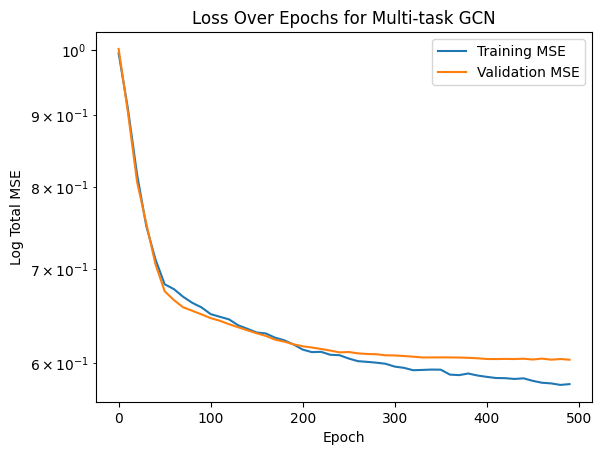

Epoch 000 | Train: 1.0009 | Val: 0.9996 * NEW BEST
Epoch 010 | Train: 0.9202 | Val: 0.9125 * NEW BEST
Epoch 020 | Train: 0.8397 | Val: 0.8167 * NEW BEST
Epoch 030 | Train: 0.7703 | Val: 0.7525 * NEW BEST
Epoch 040 | Train: 0.7395 | Val: 0.7153 * NEW BEST
Epoch 050 | Train: 0.7124 | Val: 0.6819 * NEW BEST
Epoch 060 | Train: 0.6983 | Val: 0.6683 * NEW BEST
Epoch 070 | Train: 0.6912 | Val: 0.6633 * NEW BEST
Epoch 080 | Train: 0.6840 | Val: 0.6578 * NEW BEST
Epoch 090 | Train: 0.6816 | Val: 0.6544 * NEW BEST
Epoch 100 | Train: 0.6726 | Val: 0.6506 * NEW BEST
Epoch 110 | Train: 0.6762 | Val: 0.6481 * NEW BEST
Epoch 120 | Train: 0.6639 | Val: 0.6454 * NEW BEST
Epoch 130 | Train: 0.6654 | Val: 0.6424 * NEW BEST
Epoch 140 | Train: 0.6580 | Val: 0.6405 * NEW BEST
Epoch 150 | Train: 0.6552 | Val: 0.6386 * NEW BEST
Epoch 160 | Train: 0.6540 | Val: 0.6363 * NEW BEST
Epoch 170 | Train: 0.6526 | Val: 0.6344 * NEW BEST
Epoch 180 | Train: 0.6503 | Val: 0.6319 * NEW BEST
Epoch 190 | Train: 0.6437 | Val

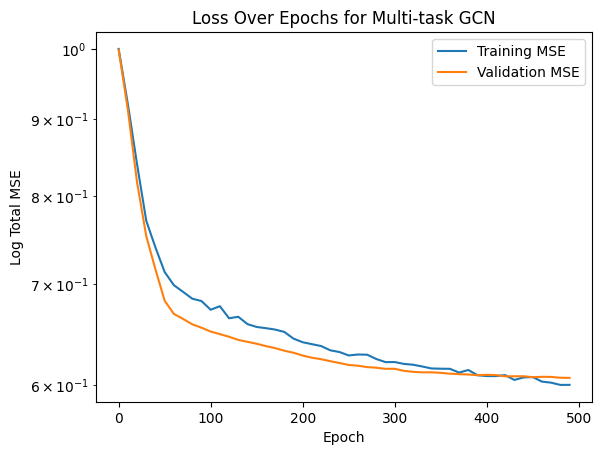

Epoch 000 | Train: 1.0002 | Val: 1.0145 * NEW BEST
Epoch 010 | Train: 0.9859 | Val: 0.9987 * NEW BEST
Epoch 020 | Train: 0.9723 | Val: 0.9836 * NEW BEST
Epoch 030 | Train: 0.9590 | Val: 0.9683 * NEW BEST
Epoch 040 | Train: 0.9444 | Val: 0.9520 * NEW BEST
Epoch 050 | Train: 0.9276 | Val: 0.9337 * NEW BEST
Epoch 060 | Train: 0.9101 | Val: 0.9133 * NEW BEST
Epoch 070 | Train: 0.8879 | Val: 0.8910 * NEW BEST
Epoch 080 | Train: 0.8664 | Val: 0.8674 * NEW BEST
Epoch 090 | Train: 0.8450 | Val: 0.8436 * NEW BEST
Epoch 100 | Train: 0.8224 | Val: 0.8207 * NEW BEST
Epoch 110 | Train: 0.8007 | Val: 0.8000 * NEW BEST
Epoch 120 | Train: 0.7825 | Val: 0.7825 * NEW BEST
Epoch 130 | Train: 0.7674 | Val: 0.7683 * NEW BEST
Epoch 140 | Train: 0.7540 | Val: 0.7567 * NEW BEST
Epoch 150 | Train: 0.7443 | Val: 0.7464 * NEW BEST
Epoch 160 | Train: 0.7337 | Val: 0.7364 * NEW BEST
Epoch 170 | Train: 0.7229 | Val: 0.7265 * NEW BEST
Epoch 180 | Train: 0.7146 | Val: 0.7168 * NEW BEST
Epoch 190 | Train: 0.7052 | Val

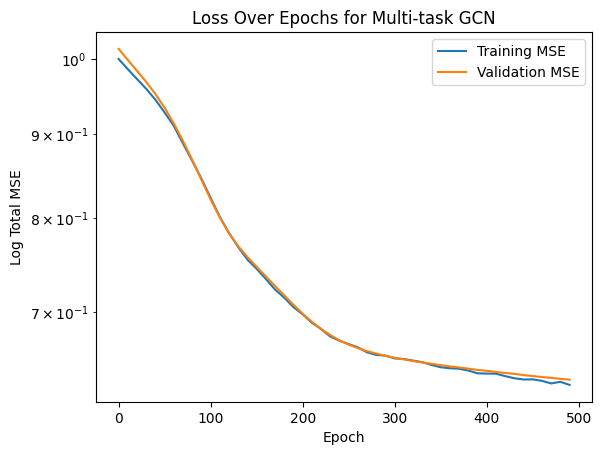

Epoch 000 | Train: 0.9915 | Val: 0.9880 * NEW BEST
Epoch 010 | Train: 0.9753 | Val: 0.9714 * NEW BEST
Epoch 020 | Train: 0.9561 | Val: 0.9551 * NEW BEST
Epoch 030 | Train: 0.9426 | Val: 0.9387 * NEW BEST
Epoch 040 | Train: 0.9279 | Val: 0.9216 * NEW BEST
Epoch 050 | Train: 0.9090 | Val: 0.9035 * NEW BEST
Epoch 060 | Train: 0.8930 | Val: 0.8846 * NEW BEST
Epoch 070 | Train: 0.8711 | Val: 0.8649 * NEW BEST
Epoch 080 | Train: 0.8581 | Val: 0.8452 * NEW BEST
Epoch 090 | Train: 0.8378 | Val: 0.8265 * NEW BEST
Epoch 100 | Train: 0.8169 | Val: 0.8094 * NEW BEST
Epoch 110 | Train: 0.8043 | Val: 0.7945 * NEW BEST
Epoch 120 | Train: 0.7953 | Val: 0.7818 * NEW BEST
Epoch 130 | Train: 0.7779 | Val: 0.7705 * NEW BEST
Epoch 140 | Train: 0.7737 | Val: 0.7603 * NEW BEST
Epoch 150 | Train: 0.7645 | Val: 0.7508 * NEW BEST
Epoch 160 | Train: 0.7519 | Val: 0.7419 * NEW BEST
Epoch 170 | Train: 0.7476 | Val: 0.7336 * NEW BEST
Epoch 180 | Train: 0.7396 | Val: 0.7257 * NEW BEST
Epoch 190 | Train: 0.7301 | Val

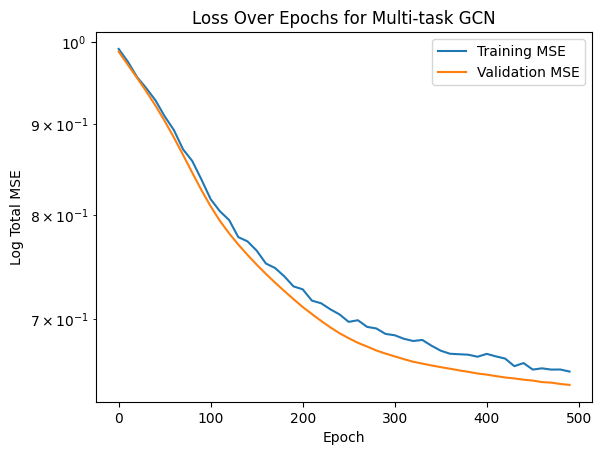

Epoch 000 | Train: 1.0175 | Val: 1.0220 * NEW BEST
Epoch 010 | Train: 0.9948 | Val: 1.0048 * NEW BEST
Epoch 020 | Train: 0.9843 | Val: 0.9892 * NEW BEST
Epoch 030 | Train: 0.9721 | Val: 0.9744 * NEW BEST
Epoch 040 | Train: 0.9620 | Val: 0.9593 * NEW BEST
Epoch 050 | Train: 0.9472 | Val: 0.9432 * NEW BEST
Epoch 060 | Train: 0.9344 | Val: 0.9256 * NEW BEST
Epoch 070 | Train: 0.9175 | Val: 0.9061 * NEW BEST
Epoch 080 | Train: 0.9002 | Val: 0.8849 * NEW BEST
Epoch 090 | Train: 0.8852 | Val: 0.8628 * NEW BEST
Epoch 100 | Train: 0.8611 | Val: 0.8408 * NEW BEST
Epoch 110 | Train: 0.8451 | Val: 0.8194 * NEW BEST
Epoch 120 | Train: 0.8272 | Val: 0.8000 * NEW BEST
Epoch 130 | Train: 0.8118 | Val: 0.7831 * NEW BEST
Epoch 140 | Train: 0.7994 | Val: 0.7690 * NEW BEST
Epoch 150 | Train: 0.7943 | Val: 0.7573 * NEW BEST
Epoch 160 | Train: 0.7805 | Val: 0.7472 * NEW BEST
Epoch 170 | Train: 0.7703 | Val: 0.7382 * NEW BEST
Epoch 180 | Train: 0.7680 | Val: 0.7301 * NEW BEST
Epoch 190 | Train: 0.7597 | Val

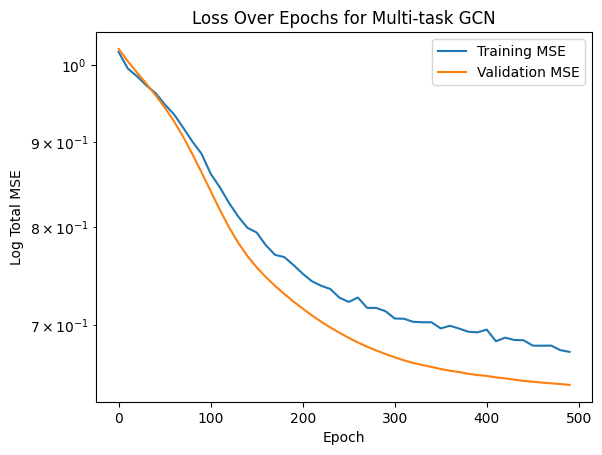

Epoch 000 | Train: 1.0221 | Val: 1.0188 * NEW BEST
Epoch 010 | Train: 1.0031 | Val: 1.0008 * NEW BEST
Epoch 020 | Train: 0.9850 | Val: 0.9850 * NEW BEST
Epoch 030 | Train: 0.9744 | Val: 0.9704 * NEW BEST
Epoch 040 | Train: 0.9602 | Val: 0.9559 * NEW BEST
Epoch 050 | Train: 0.9496 | Val: 0.9409 * NEW BEST
Epoch 060 | Train: 0.9378 | Val: 0.9249 * NEW BEST
Epoch 070 | Train: 0.9201 | Val: 0.9078 * NEW BEST
Epoch 080 | Train: 0.9123 | Val: 0.8898 * NEW BEST
Epoch 090 | Train: 0.8928 | Val: 0.8710 * NEW BEST
Epoch 100 | Train: 0.8761 | Val: 0.8524 * NEW BEST
Epoch 110 | Train: 0.8674 | Val: 0.8348 * NEW BEST
Epoch 120 | Train: 0.8501 | Val: 0.8184 * NEW BEST
Epoch 130 | Train: 0.8432 | Val: 0.8034 * NEW BEST
Epoch 140 | Train: 0.8310 | Val: 0.7910 * NEW BEST
Epoch 150 | Train: 0.8279 | Val: 0.7800 * NEW BEST
Epoch 160 | Train: 0.8194 | Val: 0.7702 * NEW BEST
Epoch 170 | Train: 0.8143 | Val: 0.7616 * NEW BEST
Epoch 180 | Train: 0.8081 | Val: 0.7539 * NEW BEST
Epoch 190 | Train: 0.7978 | Val

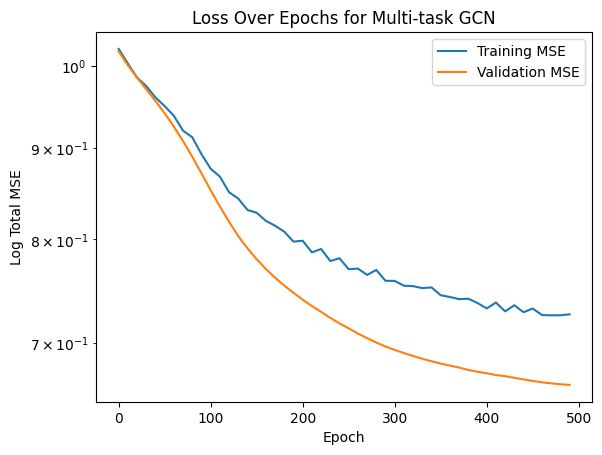

Epoch 000 | Train: 1.0072 | Val: 1.0214 * NEW BEST
Epoch 010 | Train: 0.9762 | Val: 0.9870 * NEW BEST
Epoch 020 | Train: 0.9484 | Val: 0.9551 * NEW BEST
Epoch 030 | Train: 0.9186 | Val: 0.9228 * NEW BEST
Epoch 040 | Train: 0.8875 | Val: 0.8886 * NEW BEST
Epoch 050 | Train: 0.8541 | Val: 0.8533 * NEW BEST
Epoch 060 | Train: 0.8200 | Val: 0.8194 * NEW BEST
Epoch 070 | Train: 0.7877 | Val: 0.7902 * NEW BEST
Epoch 080 | Train: 0.7632 | Val: 0.7675 * NEW BEST
Epoch 090 | Train: 0.7434 | Val: 0.7498 * NEW BEST
Epoch 100 | Train: 0.7276 | Val: 0.7341 * NEW BEST
Epoch 110 | Train: 0.7137 | Val: 0.7193 * NEW BEST
Epoch 120 | Train: 0.7002 | Val: 0.7064 * NEW BEST
Epoch 130 | Train: 0.6898 | Val: 0.6955 * NEW BEST
Epoch 140 | Train: 0.6809 | Val: 0.6866 * NEW BEST
Epoch 150 | Train: 0.6740 | Val: 0.6794 * NEW BEST
Epoch 160 | Train: 0.6675 | Val: 0.6738 * NEW BEST
Epoch 170 | Train: 0.6627 | Val: 0.6693 * NEW BEST
Epoch 180 | Train: 0.6590 | Val: 0.6654 * NEW BEST
Epoch 190 | Train: 0.6569 | Val

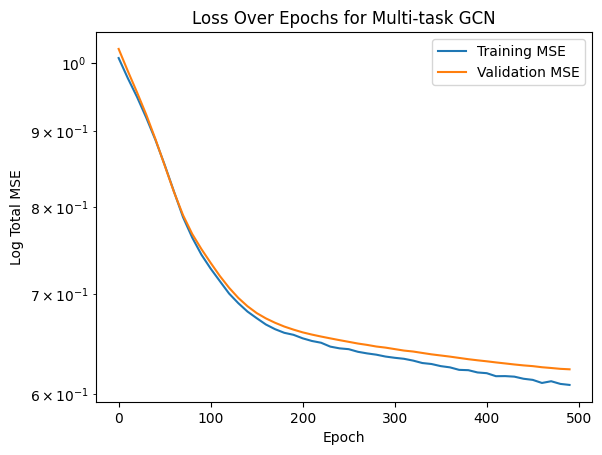

Epoch 000 | Train: 0.9965 | Val: 1.0076 * NEW BEST
Epoch 010 | Train: 0.9721 | Val: 0.9807 * NEW BEST
Epoch 020 | Train: 0.9475 | Val: 0.9530 * NEW BEST
Epoch 030 | Train: 0.9213 | Val: 0.9224 * NEW BEST
Epoch 040 | Train: 0.8894 | Val: 0.8880 * NEW BEST
Epoch 050 | Train: 0.8552 | Val: 0.8502 * NEW BEST
Epoch 060 | Train: 0.8194 | Val: 0.8125 * NEW BEST
Epoch 070 | Train: 0.7884 | Val: 0.7791 * NEW BEST
Epoch 080 | Train: 0.7590 | Val: 0.7527 * NEW BEST
Epoch 090 | Train: 0.7409 | Val: 0.7329 * NEW BEST
Epoch 100 | Train: 0.7235 | Val: 0.7172 * NEW BEST
Epoch 110 | Train: 0.7107 | Val: 0.7037 * NEW BEST
Epoch 120 | Train: 0.7023 | Val: 0.6922 * NEW BEST
Epoch 130 | Train: 0.6924 | Val: 0.6828 * NEW BEST
Epoch 140 | Train: 0.6870 | Val: 0.6753 * NEW BEST
Epoch 150 | Train: 0.6783 | Val: 0.6700 * NEW BEST
Epoch 160 | Train: 0.6749 | Val: 0.6659 * NEW BEST
Epoch 170 | Train: 0.6703 | Val: 0.6625 * NEW BEST
Epoch 180 | Train: 0.6693 | Val: 0.6599 * NEW BEST
Epoch 190 | Train: 0.6666 | Val

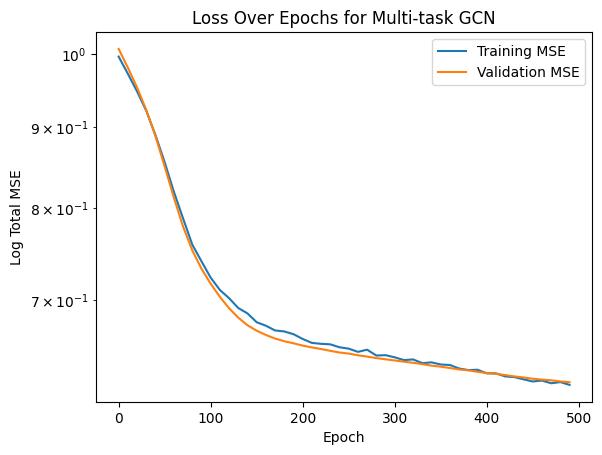

Epoch 000 | Train: 0.9954 | Val: 1.0080 * NEW BEST
Epoch 010 | Train: 0.9677 | Val: 0.9796 * NEW BEST
Epoch 020 | Train: 0.9471 | Val: 0.9529 * NEW BEST
Epoch 030 | Train: 0.9241 | Val: 0.9250 * NEW BEST
Epoch 040 | Train: 0.8993 | Val: 0.8941 * NEW BEST
Epoch 050 | Train: 0.8712 | Val: 0.8594 * NEW BEST
Epoch 060 | Train: 0.8417 | Val: 0.8224 * NEW BEST
Epoch 070 | Train: 0.8046 | Val: 0.7863 * NEW BEST
Epoch 080 | Train: 0.7763 | Val: 0.7554 * NEW BEST
Epoch 090 | Train: 0.7551 | Val: 0.7320 * NEW BEST
Epoch 100 | Train: 0.7362 | Val: 0.7152 * NEW BEST
Epoch 110 | Train: 0.7251 | Val: 0.7019 * NEW BEST
Epoch 120 | Train: 0.7168 | Val: 0.6909 * NEW BEST
Epoch 130 | Train: 0.7067 | Val: 0.6825 * NEW BEST
Epoch 140 | Train: 0.7017 | Val: 0.6758 * NEW BEST
Epoch 150 | Train: 0.6929 | Val: 0.6709 * NEW BEST
Epoch 160 | Train: 0.6899 | Val: 0.6668 * NEW BEST
Epoch 170 | Train: 0.6855 | Val: 0.6633 * NEW BEST
Epoch 180 | Train: 0.6865 | Val: 0.6604 * NEW BEST
Epoch 190 | Train: 0.6823 | Val

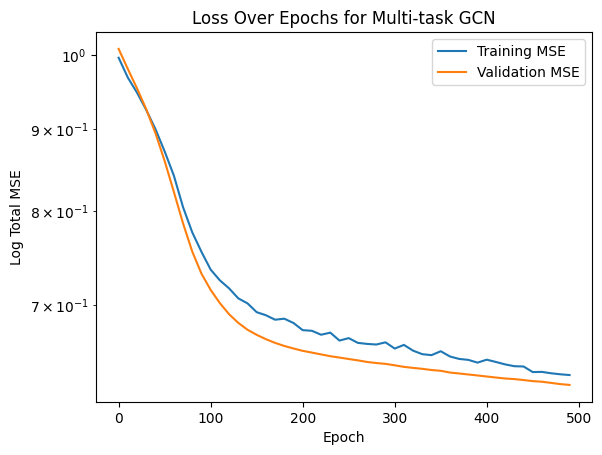

Epoch 000 | Train: 1.0064 | Val: 1.0142 * NEW BEST
Epoch 010 | Train: 0.9830 | Val: 0.9879 * NEW BEST
Epoch 020 | Train: 0.9612 | Val: 0.9624 * NEW BEST
Epoch 030 | Train: 0.9375 | Val: 0.9356 * NEW BEST
Epoch 040 | Train: 0.9166 | Val: 0.9062 * NEW BEST
Epoch 050 | Train: 0.8875 | Val: 0.8740 * NEW BEST
Epoch 060 | Train: 0.8583 | Val: 0.8408 * NEW BEST
Epoch 070 | Train: 0.8340 | Val: 0.8089 * NEW BEST
Epoch 080 | Train: 0.8136 | Val: 0.7812 * NEW BEST
Epoch 090 | Train: 0.7920 | Val: 0.7591 * NEW BEST
Epoch 100 | Train: 0.7840 | Val: 0.7422 * NEW BEST
Epoch 110 | Train: 0.7710 | Val: 0.7285 * NEW BEST
Epoch 120 | Train: 0.7567 | Val: 0.7168 * NEW BEST
Epoch 130 | Train: 0.7554 | Val: 0.7068 * NEW BEST
Epoch 140 | Train: 0.7416 | Val: 0.6982 * NEW BEST
Epoch 150 | Train: 0.7410 | Val: 0.6910 * NEW BEST
Epoch 160 | Train: 0.7281 | Val: 0.6852 * NEW BEST
Epoch 170 | Train: 0.7216 | Val: 0.6802 * NEW BEST
Epoch 180 | Train: 0.7230 | Val: 0.6760 * NEW BEST
Epoch 190 | Train: 0.7137 | Val

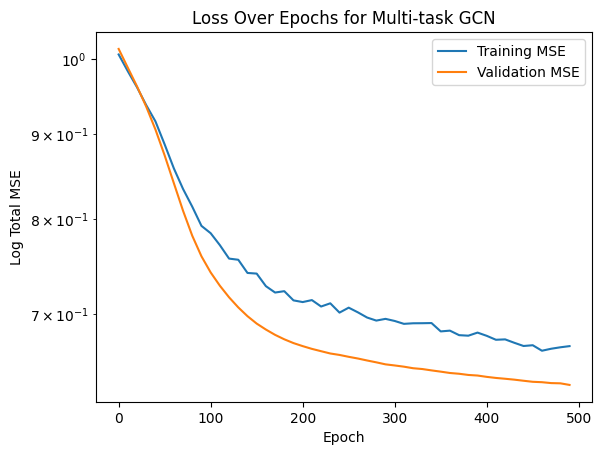

Epoch 000 | Train: 0.9960 | Val: 1.0103 * NEW BEST
Epoch 010 | Train: 0.9598 | Val: 0.9692 * NEW BEST
Epoch 020 | Train: 0.9190 | Val: 0.9237 * NEW BEST
Epoch 030 | Train: 0.8677 | Val: 0.8682 * NEW BEST
Epoch 040 | Train: 0.8101 | Val: 0.8079 * NEW BEST
Epoch 050 | Train: 0.7573 | Val: 0.7581 * NEW BEST
Epoch 060 | Train: 0.7201 | Val: 0.7268 * NEW BEST
Epoch 070 | Train: 0.6954 | Val: 0.7032 * NEW BEST
Epoch 080 | Train: 0.6781 | Val: 0.6851 * NEW BEST
Epoch 090 | Train: 0.6663 | Val: 0.6741 * NEW BEST
Epoch 100 | Train: 0.6596 | Val: 0.6676 * NEW BEST
Epoch 110 | Train: 0.6540 | Val: 0.6631 * NEW BEST
Epoch 120 | Train: 0.6501 | Val: 0.6595 * NEW BEST
Epoch 130 | Train: 0.6467 | Val: 0.6568 * NEW BEST
Epoch 140 | Train: 0.6436 | Val: 0.6544 * NEW BEST
Epoch 150 | Train: 0.6411 | Val: 0.6518 * NEW BEST
Epoch 160 | Train: 0.6385 | Val: 0.6496 * NEW BEST
Epoch 170 | Train: 0.6357 | Val: 0.6474 * NEW BEST
Epoch 180 | Train: 0.6337 | Val: 0.6452 * NEW BEST
Epoch 190 | Train: 0.6310 | Val

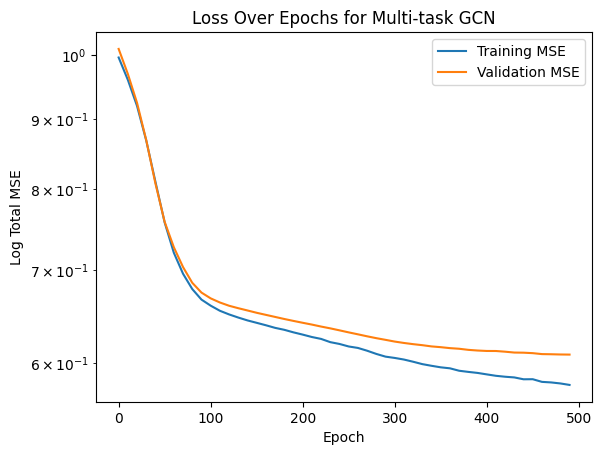

Epoch 000 | Train: 0.9994 | Val: 1.0115 * NEW BEST
Epoch 010 | Train: 0.9556 | Val: 0.9637 * NEW BEST
Epoch 020 | Train: 0.9128 | Val: 0.9147 * NEW BEST
Epoch 030 | Train: 0.8635 | Val: 0.8597 * NEW BEST
Epoch 040 | Train: 0.8084 | Val: 0.8038 * NEW BEST
Epoch 050 | Train: 0.7619 | Val: 0.7591 * NEW BEST
Epoch 060 | Train: 0.7284 | Val: 0.7296 * NEW BEST
Epoch 070 | Train: 0.7067 | Val: 0.7065 * NEW BEST
Epoch 080 | Train: 0.6882 | Val: 0.6885 * NEW BEST
Epoch 090 | Train: 0.6772 | Val: 0.6774 * NEW BEST
Epoch 100 | Train: 0.6713 | Val: 0.6706 * NEW BEST
Epoch 110 | Train: 0.6647 | Val: 0.6657 * NEW BEST
Epoch 120 | Train: 0.6625 | Val: 0.6618 * NEW BEST
Epoch 130 | Train: 0.6603 | Val: 0.6589 * NEW BEST
Epoch 140 | Train: 0.6541 | Val: 0.6564 * NEW BEST
Epoch 150 | Train: 0.6500 | Val: 0.6537 * NEW BEST
Epoch 160 | Train: 0.6501 | Val: 0.6510 * NEW BEST
Epoch 170 | Train: 0.6444 | Val: 0.6486 * NEW BEST
Epoch 180 | Train: 0.6436 | Val: 0.6465 * NEW BEST
Epoch 190 | Train: 0.6408 | Val

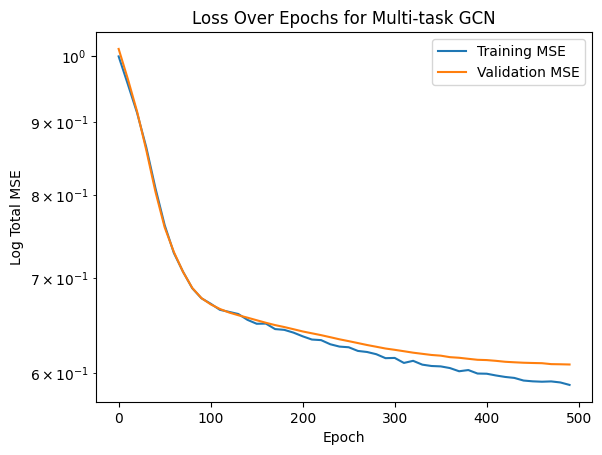

Epoch 000 | Train: 1.0014 | Val: 1.0083 * NEW BEST
Epoch 010 | Train: 0.9564 | Val: 0.9588 * NEW BEST
Epoch 020 | Train: 0.9151 | Val: 0.9114 * NEW BEST
Epoch 030 | Train: 0.8666 | Val: 0.8607 * NEW BEST
Epoch 040 | Train: 0.8192 | Val: 0.8103 * NEW BEST
Epoch 050 | Train: 0.7795 | Val: 0.7703 * NEW BEST
Epoch 060 | Train: 0.7468 | Val: 0.7442 * NEW BEST
Epoch 070 | Train: 0.7235 | Val: 0.7206 * NEW BEST
Epoch 080 | Train: 0.7040 | Val: 0.6991 * NEW BEST
Epoch 090 | Train: 0.6914 | Val: 0.6836 * NEW BEST
Epoch 100 | Train: 0.6832 | Val: 0.6743 * NEW BEST
Epoch 110 | Train: 0.6799 | Val: 0.6683 * NEW BEST
Epoch 120 | Train: 0.6737 | Val: 0.6638 * NEW BEST
Epoch 130 | Train: 0.6682 | Val: 0.6605 * NEW BEST
Epoch 140 | Train: 0.6663 | Val: 0.6575 * NEW BEST
Epoch 150 | Train: 0.6633 | Val: 0.6551 * NEW BEST
Epoch 160 | Train: 0.6600 | Val: 0.6529 * NEW BEST
Epoch 170 | Train: 0.6562 | Val: 0.6505 * NEW BEST
Epoch 180 | Train: 0.6519 | Val: 0.6484 * NEW BEST
Epoch 190 | Train: 0.6497 | Val

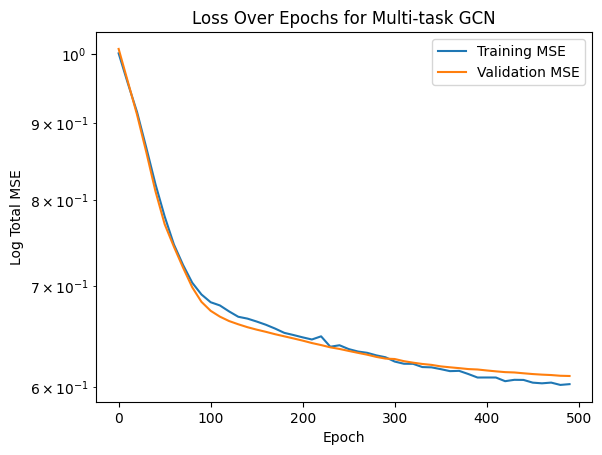

Epoch 000 | Train: 0.9926 | Val: 0.9986 * NEW BEST
Epoch 010 | Train: 0.9507 | Val: 0.9531 * NEW BEST
Epoch 020 | Train: 0.9128 | Val: 0.9057 * NEW BEST
Epoch 030 | Train: 0.8672 | Val: 0.8529 * NEW BEST
Epoch 040 | Train: 0.8221 | Val: 0.8023 * NEW BEST
Epoch 050 | Train: 0.7841 | Val: 0.7657 * NEW BEST
Epoch 060 | Train: 0.7629 | Val: 0.7402 * NEW BEST
Epoch 070 | Train: 0.7348 | Val: 0.7169 * NEW BEST
Epoch 080 | Train: 0.7300 | Val: 0.6980 * NEW BEST
Epoch 090 | Train: 0.7169 | Val: 0.6841 * NEW BEST
Epoch 100 | Train: 0.7030 | Val: 0.6753 * NEW BEST
Epoch 110 | Train: 0.7005 | Val: 0.6691 * NEW BEST
Epoch 120 | Train: 0.6954 | Val: 0.6646 * NEW BEST
Epoch 130 | Train: 0.6873 | Val: 0.6618 * NEW BEST
Epoch 140 | Train: 0.6861 | Val: 0.6592 * NEW BEST
Epoch 150 | Train: 0.6808 | Val: 0.6571 * NEW BEST
Epoch 160 | Train: 0.6788 | Val: 0.6553 * NEW BEST
Epoch 170 | Train: 0.6791 | Val: 0.6529 * NEW BEST
Epoch 180 | Train: 0.6743 | Val: 0.6504 * NEW BEST
Epoch 190 | Train: 0.6751 | Val

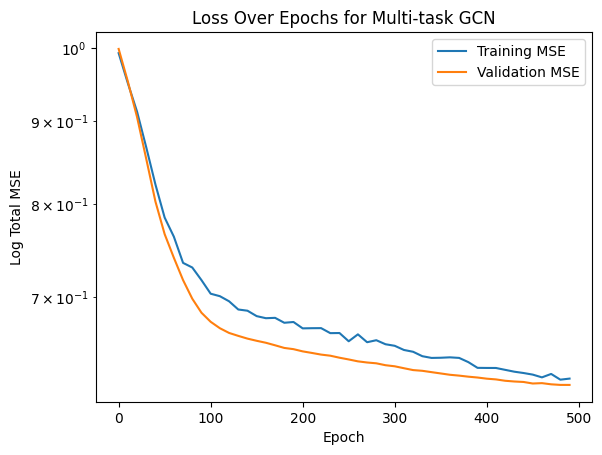

Epoch 000 | Train: 1.0001 | Val: 1.0156 * NEW BEST
Epoch 010 | Train: 0.9742 | Val: 0.9862 * NEW BEST
Epoch 020 | Train: 0.9501 | Val: 0.9585 * NEW BEST
Epoch 030 | Train: 0.9238 | Val: 0.9279 * NEW BEST
Epoch 040 | Train: 0.8909 | Val: 0.8921 * NEW BEST
Epoch 050 | Train: 0.8539 | Val: 0.8525 * NEW BEST
Epoch 060 | Train: 0.8159 | Val: 0.8143 * NEW BEST
Epoch 070 | Train: 0.7829 | Val: 0.7817 * NEW BEST
Epoch 080 | Train: 0.7589 | Val: 0.7559 * NEW BEST
Epoch 090 | Train: 0.7334 | Val: 0.7341 * NEW BEST
Epoch 100 | Train: 0.7128 | Val: 0.7148 * NEW BEST
Epoch 110 | Train: 0.6971 | Val: 0.6977 * NEW BEST
Epoch 120 | Train: 0.6823 | Val: 0.6838 * NEW BEST
Epoch 130 | Train: 0.6724 | Val: 0.6739 * NEW BEST
Epoch 140 | Train: 0.6659 | Val: 0.6671 * NEW BEST
Epoch 150 | Train: 0.6610 | Val: 0.6620 * NEW BEST
Epoch 160 | Train: 0.6547 | Val: 0.6578 * NEW BEST
Epoch 170 | Train: 0.6524 | Val: 0.6547 * NEW BEST
Epoch 180 | Train: 0.6492 | Val: 0.6523 * NEW BEST
Epoch 190 | Train: 0.6456 | Val

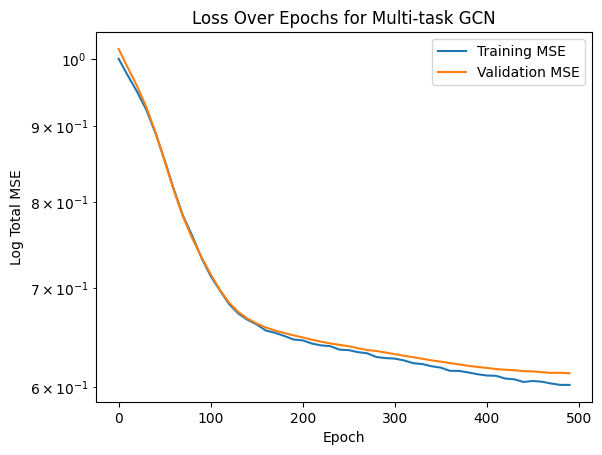

Epoch 000 | Train: 1.0208 | Val: 1.0412 * NEW BEST
Epoch 010 | Train: 0.9878 | Val: 1.0026 * NEW BEST
Epoch 020 | Train: 0.9568 | Val: 0.9671 * NEW BEST
Epoch 030 | Train: 0.9273 | Val: 0.9311 * NEW BEST
Epoch 040 | Train: 0.8945 | Val: 0.8938 * NEW BEST
Epoch 050 | Train: 0.8598 | Val: 0.8558 * NEW BEST
Epoch 060 | Train: 0.8270 | Val: 0.8197 * NEW BEST
Epoch 070 | Train: 0.7949 | Val: 0.7877 * NEW BEST
Epoch 080 | Train: 0.7717 | Val: 0.7611 * NEW BEST
Epoch 090 | Train: 0.7511 | Val: 0.7393 * NEW BEST
Epoch 100 | Train: 0.7315 | Val: 0.7211 * NEW BEST
Epoch 110 | Train: 0.7145 | Val: 0.7052 * NEW BEST
Epoch 120 | Train: 0.7078 | Val: 0.6920 * NEW BEST
Epoch 130 | Train: 0.6995 | Val: 0.6809 * NEW BEST
Epoch 140 | Train: 0.6869 | Val: 0.6720 * NEW BEST
Epoch 150 | Train: 0.6789 | Val: 0.6650 * NEW BEST
Epoch 160 | Train: 0.6774 | Val: 0.6600 * NEW BEST
Epoch 170 | Train: 0.6703 | Val: 0.6562 * NEW BEST
Epoch 180 | Train: 0.6694 | Val: 0.6532 * NEW BEST
Epoch 190 | Train: 0.6672 | Val

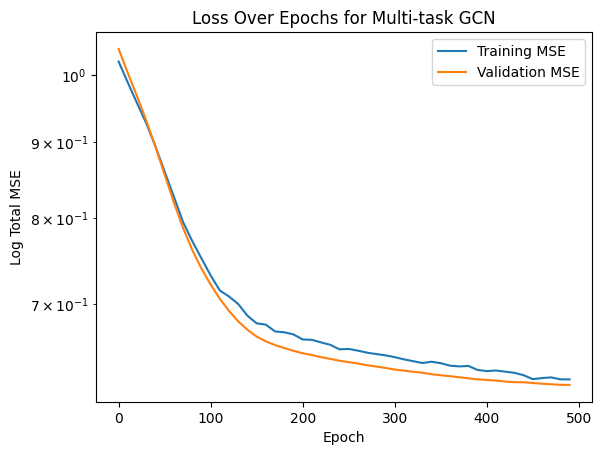

Epoch 000 | Train: 1.0132 | Val: 1.0131 * NEW BEST
Epoch 010 | Train: 0.9815 | Val: 0.9837 * NEW BEST
Epoch 020 | Train: 0.9580 | Val: 0.9548 * NEW BEST
Epoch 030 | Train: 0.9272 | Val: 0.9222 * NEW BEST
Epoch 040 | Train: 0.8947 | Val: 0.8842 * NEW BEST
Epoch 050 | Train: 0.8624 | Val: 0.8439 * NEW BEST
Epoch 060 | Train: 0.8288 | Val: 0.8067 * NEW BEST
Epoch 070 | Train: 0.8066 | Val: 0.7772 * NEW BEST
Epoch 080 | Train: 0.7782 | Val: 0.7550 * NEW BEST
Epoch 090 | Train: 0.7661 | Val: 0.7366 * NEW BEST
Epoch 100 | Train: 0.7596 | Val: 0.7208 * NEW BEST
Epoch 110 | Train: 0.7471 | Val: 0.7077 * NEW BEST
Epoch 120 | Train: 0.7372 | Val: 0.6962 * NEW BEST
Epoch 130 | Train: 0.7276 | Val: 0.6867 * NEW BEST
Epoch 140 | Train: 0.7215 | Val: 0.6793 * NEW BEST
Epoch 150 | Train: 0.7113 | Val: 0.6730 * NEW BEST
Epoch 160 | Train: 0.7087 | Val: 0.6684 * NEW BEST
Epoch 170 | Train: 0.7044 | Val: 0.6647 * NEW BEST
Epoch 180 | Train: 0.7051 | Val: 0.6621 * NEW BEST
Epoch 190 | Train: 0.6979 | Val

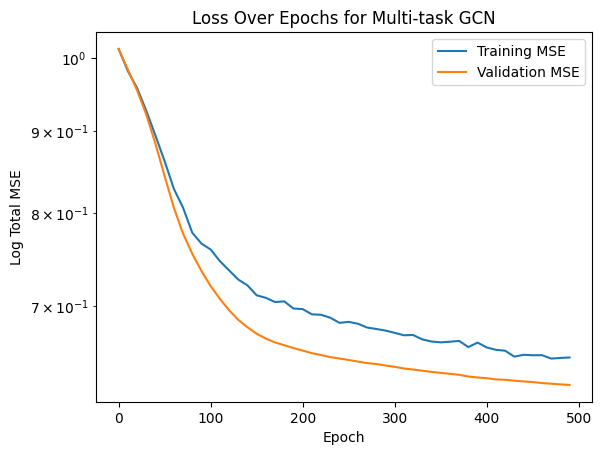

Epoch 000 | Train: 1.0088 | Val: 1.0122 * NEW BEST
Epoch 010 | Train: 0.9792 | Val: 0.9823 * NEW BEST
Epoch 020 | Train: 0.9520 | Val: 0.9541 * NEW BEST
Epoch 030 | Train: 0.9330 | Val: 0.9251 * NEW BEST
Epoch 040 | Train: 0.9069 | Val: 0.8944 * NEW BEST
Epoch 050 | Train: 0.8804 | Val: 0.8618 * NEW BEST
Epoch 060 | Train: 0.8573 | Val: 0.8302 * NEW BEST
Epoch 070 | Train: 0.8374 | Val: 0.8024 * NEW BEST
Epoch 080 | Train: 0.8161 | Val: 0.7805 * NEW BEST
Epoch 090 | Train: 0.8104 | Val: 0.7639 * NEW BEST
Epoch 100 | Train: 0.7916 | Val: 0.7507 * NEW BEST
Epoch 110 | Train: 0.7933 | Val: 0.7394 * NEW BEST
Epoch 120 | Train: 0.7834 | Val: 0.7292 * NEW BEST
Epoch 130 | Train: 0.7734 | Val: 0.7201 * NEW BEST
Epoch 140 | Train: 0.7696 | Val: 0.7118 * NEW BEST
Epoch 150 | Train: 0.7590 | Val: 0.7050 * NEW BEST
Epoch 160 | Train: 0.7508 | Val: 0.6989 * NEW BEST
Epoch 170 | Train: 0.7557 | Val: 0.6933 * NEW BEST
Epoch 180 | Train: 0.7432 | Val: 0.6889 * NEW BEST
Epoch 190 | Train: 0.7426 | Val

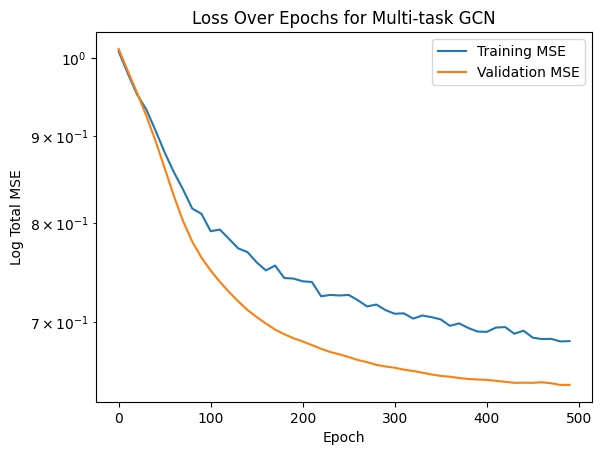

Epoch 000 | Train: 1.0082 | Val: 1.0217 * NEW BEST
Epoch 010 | Train: 0.9577 | Val: 0.9675 * NEW BEST
Epoch 020 | Train: 0.9075 | Val: 0.9109 * NEW BEST
Epoch 030 | Train: 0.8461 | Val: 0.8458 * NEW BEST
Epoch 040 | Train: 0.7850 | Val: 0.7850 * NEW BEST
Epoch 050 | Train: 0.7399 | Val: 0.7456 * NEW BEST
Epoch 060 | Train: 0.7107 | Val: 0.7165 * NEW BEST
Epoch 070 | Train: 0.6876 | Val: 0.6911 * NEW BEST
Epoch 080 | Train: 0.6723 | Val: 0.6742 * NEW BEST
Epoch 090 | Train: 0.6606 | Val: 0.6644 * NEW BEST
Epoch 100 | Train: 0.6548 | Val: 0.6581 * NEW BEST
Epoch 110 | Train: 0.6485 | Val: 0.6540 * NEW BEST
Epoch 120 | Train: 0.6445 | Val: 0.6509 * NEW BEST
Epoch 130 | Train: 0.6403 | Val: 0.6476 * NEW BEST
Epoch 140 | Train: 0.6373 | Val: 0.6447 * NEW BEST
Epoch 150 | Train: 0.6344 | Val: 0.6421 * NEW BEST
Epoch 160 | Train: 0.6315 | Val: 0.6398 * NEW BEST
Epoch 170 | Train: 0.6289 | Val: 0.6372 * NEW BEST
Epoch 180 | Train: 0.6264 | Val: 0.6349 * NEW BEST
Epoch 190 | Train: 0.6258 | Val

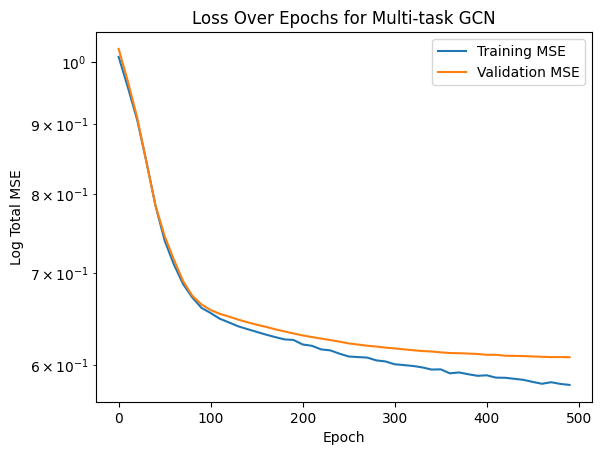

Epoch 000 | Train: 0.9910 | Val: 0.9918 * NEW BEST
Epoch 010 | Train: 0.9333 | Val: 0.9313 * NEW BEST
Epoch 020 | Train: 0.8774 | Val: 0.8694 * NEW BEST
Epoch 030 | Train: 0.8166 | Val: 0.8096 * NEW BEST
Epoch 040 | Train: 0.7729 | Val: 0.7702 * NEW BEST
Epoch 050 | Train: 0.7451 | Val: 0.7443 * NEW BEST
Epoch 060 | Train: 0.7196 | Val: 0.7163 * NEW BEST
Epoch 070 | Train: 0.7000 | Val: 0.6944 * NEW BEST
Epoch 080 | Train: 0.6825 | Val: 0.6802 * NEW BEST
Epoch 090 | Train: 0.6766 | Val: 0.6696 * NEW BEST
Epoch 100 | Train: 0.6679 | Val: 0.6621 * NEW BEST
Epoch 110 | Train: 0.6635 | Val: 0.6575 * NEW BEST
Epoch 120 | Train: 0.6599 | Val: 0.6539 * NEW BEST
Epoch 130 | Train: 0.6544 | Val: 0.6505 * NEW BEST
Epoch 140 | Train: 0.6530 | Val: 0.6476 * NEW BEST
Epoch 150 | Train: 0.6480 | Val: 0.6447 * NEW BEST
Epoch 160 | Train: 0.6452 | Val: 0.6423 * NEW BEST
Epoch 170 | Train: 0.6398 | Val: 0.6397 * NEW BEST
Epoch 180 | Train: 0.6392 | Val: 0.6371 * NEW BEST
Epoch 190 | Train: 0.6363 | Val

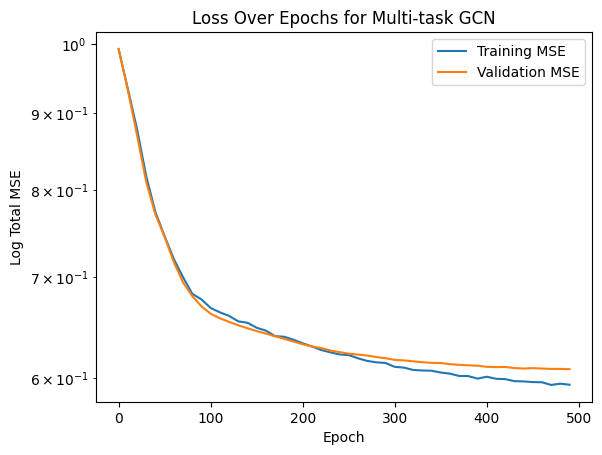

Epoch 000 | Train: 0.9903 | Val: 0.9994 * NEW BEST
Epoch 010 | Train: 0.9436 | Val: 0.9439 * NEW BEST
Epoch 020 | Train: 0.8960 | Val: 0.8895 * NEW BEST
Epoch 030 | Train: 0.8478 | Val: 0.8335 * NEW BEST
Epoch 040 | Train: 0.7984 | Val: 0.7811 * NEW BEST
Epoch 050 | Train: 0.7624 | Val: 0.7417 * NEW BEST
Epoch 060 | Train: 0.7334 | Val: 0.7153 * NEW BEST
Epoch 070 | Train: 0.7140 | Val: 0.6942 * NEW BEST
Epoch 080 | Train: 0.7034 | Val: 0.6799 * NEW BEST
Epoch 090 | Train: 0.6952 | Val: 0.6708 * NEW BEST
Epoch 100 | Train: 0.6909 | Val: 0.6640 * NEW BEST
Epoch 110 | Train: 0.6840 | Val: 0.6599 * NEW BEST
Epoch 120 | Train: 0.6744 | Val: 0.6559 * NEW BEST
Epoch 130 | Train: 0.6706 | Val: 0.6525 * NEW BEST
Epoch 140 | Train: 0.6706 | Val: 0.6495 * NEW BEST
Epoch 150 | Train: 0.6642 | Val: 0.6467 * NEW BEST
Epoch 160 | Train: 0.6639 | Val: 0.6444 * NEW BEST
Epoch 170 | Train: 0.6593 | Val: 0.6419 * NEW BEST
Epoch 180 | Train: 0.6564 | Val: 0.6394 * NEW BEST
Epoch 190 | Train: 0.6518 | Val

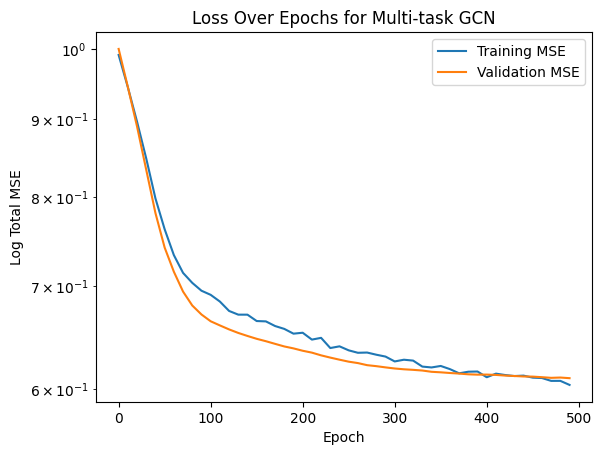

Epoch 000 | Train: 1.0274 | Val: 1.0269 * NEW BEST
Epoch 010 | Train: 0.9659 | Val: 0.9687 * NEW BEST
Epoch 020 | Train: 0.9216 | Val: 0.9151 * NEW BEST
Epoch 030 | Train: 0.8760 | Val: 0.8542 * NEW BEST
Epoch 040 | Train: 0.8289 | Val: 0.7932 * NEW BEST
Epoch 050 | Train: 0.7895 | Val: 0.7503 * NEW BEST
Epoch 060 | Train: 0.7717 | Val: 0.7257 * NEW BEST
Epoch 070 | Train: 0.7604 | Val: 0.7090 * NEW BEST
Epoch 080 | Train: 0.7408 | Val: 0.6964 * NEW BEST
Epoch 090 | Train: 0.7356 | Val: 0.6867 * NEW BEST
Epoch 100 | Train: 0.7270 | Val: 0.6785 * NEW BEST
Epoch 110 | Train: 0.7251 | Val: 0.6721 * NEW BEST
Epoch 120 | Train: 0.7177 | Val: 0.6671 * NEW BEST
Epoch 130 | Train: 0.7114 | Val: 0.6629 * NEW BEST
Epoch 140 | Train: 0.7077 | Val: 0.6598 * NEW BEST
Epoch 150 | Train: 0.7032 | Val: 0.6566 * NEW BEST
Epoch 160 | Train: 0.6993 | Val: 0.6541 * NEW BEST
Epoch 170 | Train: 0.6963 | Val: 0.6517 * NEW BEST
Epoch 180 | Train: 0.6903 | Val: 0.6491 * NEW BEST
Epoch 190 | Train: 0.6878 | Val

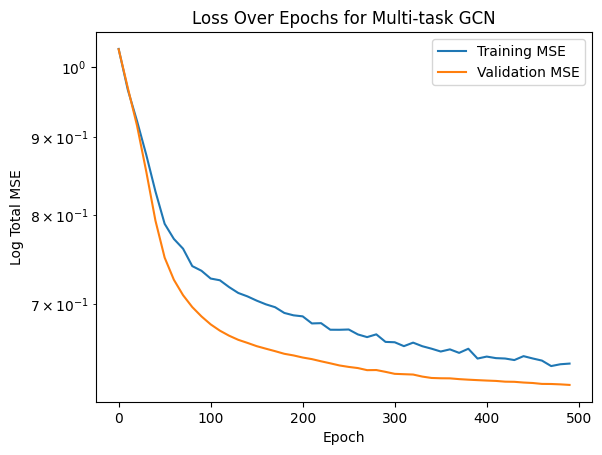

Epoch 000 | Train: 0.9993 | Val: 1.0051 * NEW BEST
Epoch 010 | Train: 0.9075 | Val: 0.9030 * NEW BEST
Epoch 020 | Train: 0.8092 | Val: 0.8016 * NEW BEST
Epoch 030 | Train: 0.7349 | Val: 0.7420 * NEW BEST
Epoch 040 | Train: 0.6961 | Val: 0.7027 * NEW BEST
Epoch 050 | Train: 0.6712 | Val: 0.6762 * NEW BEST
Epoch 060 | Train: 0.6594 | Val: 0.6676 * NEW BEST
Epoch 070 | Train: 0.6501 | Val: 0.6598 * NEW BEST
Epoch 080 | Train: 0.6444 | Val: 0.6542 * NEW BEST
Epoch 090 | Train: 0.6382 | Val: 0.6493 * NEW BEST
Epoch 100 | Train: 0.6341 | Val: 0.6447 * NEW BEST
Epoch 110 | Train: 0.6299 | Val: 0.6411 * NEW BEST
Epoch 120 | Train: 0.6260 | Val: 0.6376 * NEW BEST
Epoch 130 | Train: 0.6215 | Val: 0.6340 * NEW BEST
Epoch 140 | Train: 0.6165 | Val: 0.6308 * NEW BEST
Epoch 150 | Train: 0.6138 | Val: 0.6279 * NEW BEST
Epoch 160 | Train: 0.6105 | Val: 0.6249 * NEW BEST
Epoch 170 | Train: 0.6065 | Val: 0.6225 * NEW BEST
Epoch 180 | Train: 0.6029 | Val: 0.6204 * NEW BEST
Epoch 190 | Train: 0.6001 | Val

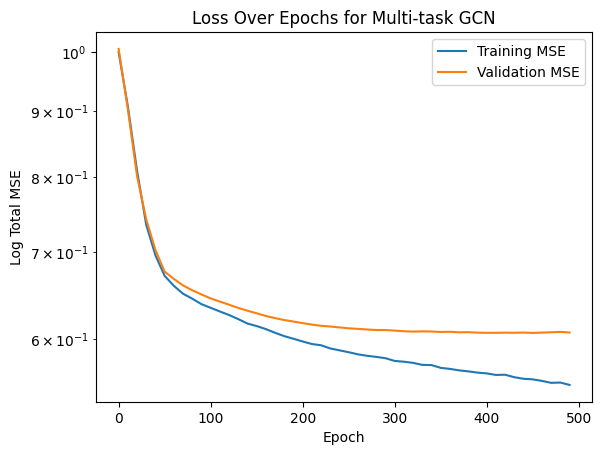

Epoch 000 | Train: 0.9926 | Val: 1.0005 * NEW BEST
Epoch 010 | Train: 0.9018 | Val: 0.8957 * NEW BEST
Epoch 020 | Train: 0.8057 | Val: 0.7959 * NEW BEST
Epoch 030 | Train: 0.7403 | Val: 0.7398 * NEW BEST
Epoch 040 | Train: 0.7010 | Val: 0.6979 * NEW BEST
Epoch 050 | Train: 0.6794 | Val: 0.6750 * NEW BEST
Epoch 060 | Train: 0.6689 | Val: 0.6665 * NEW BEST
Epoch 070 | Train: 0.6589 | Val: 0.6595 * NEW BEST
Epoch 080 | Train: 0.6521 | Val: 0.6543 * NEW BEST
Epoch 090 | Train: 0.6458 | Val: 0.6502 * NEW BEST
Epoch 100 | Train: 0.6423 | Val: 0.6453 * NEW BEST
Epoch 110 | Train: 0.6399 | Val: 0.6416 * NEW BEST
Epoch 120 | Train: 0.6341 | Val: 0.6383 * NEW BEST
Epoch 130 | Train: 0.6295 | Val: 0.6352 * NEW BEST
Epoch 140 | Train: 0.6258 | Val: 0.6317 * NEW BEST
Epoch 150 | Train: 0.6230 | Val: 0.6283 * NEW BEST
Epoch 160 | Train: 0.6202 | Val: 0.6252 * NEW BEST
Epoch 170 | Train: 0.6160 | Val: 0.6220 * NEW BEST
Epoch 180 | Train: 0.6117 | Val: 0.6194 * NEW BEST
Epoch 190 | Train: 0.6073 | Val

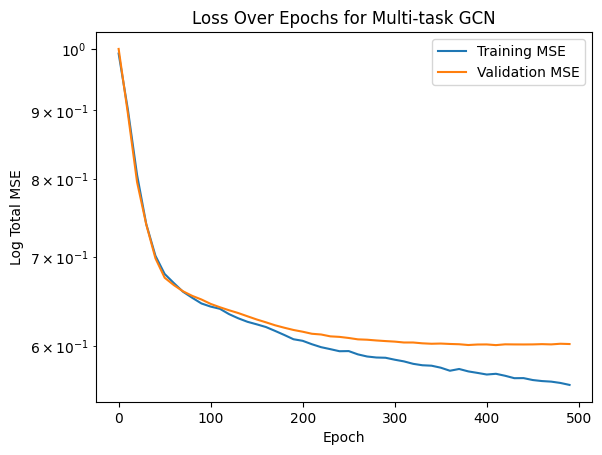

Epoch 000 | Train: 0.9884 | Val: 0.9877 * NEW BEST
Epoch 010 | Train: 0.8946 | Val: 0.8838 * NEW BEST
Epoch 020 | Train: 0.8049 | Val: 0.7916 * NEW BEST
Epoch 030 | Train: 0.7513 | Val: 0.7465 * NEW BEST
Epoch 040 | Train: 0.7133 | Val: 0.7038 * NEW BEST
Epoch 050 | Train: 0.6881 | Val: 0.6785 * NEW BEST
Epoch 060 | Train: 0.6778 | Val: 0.6657 * NEW BEST
Epoch 070 | Train: 0.6708 | Val: 0.6594 * NEW BEST
Epoch 080 | Train: 0.6643 | Val: 0.6552 * NEW BEST
Epoch 090 | Train: 0.6597 | Val: 0.6498 * NEW BEST
Epoch 100 | Train: 0.6538 | Val: 0.6466 * NEW BEST
Epoch 110 | Train: 0.6476 | Val: 0.6425 * NEW BEST
Epoch 120 | Train: 0.6420 | Val: 0.6392 * NEW BEST
Epoch 130 | Train: 0.6411 | Val: 0.6363 * NEW BEST
Epoch 140 | Train: 0.6352 | Val: 0.6337 * NEW BEST
Epoch 150 | Train: 0.6340 | Val: 0.6303 * NEW BEST
Epoch 160 | Train: 0.6299 | Val: 0.6275 * NEW BEST
Epoch 170 | Train: 0.6265 | Val: 0.6245 * NEW BEST
Epoch 180 | Train: 0.6211 | Val: 0.6230 * NEW BEST
Epoch 190 | Train: 0.6193 | Val

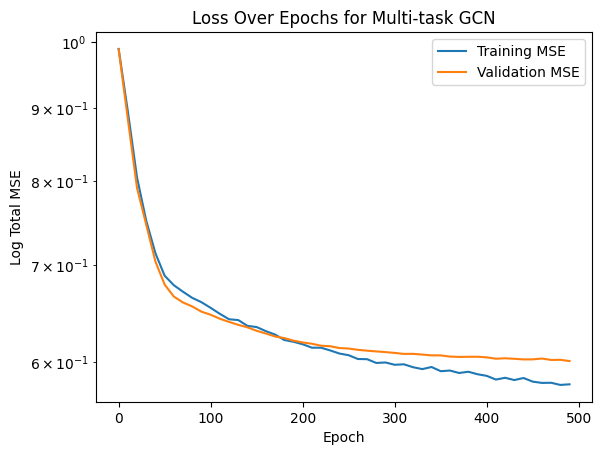

Epoch 000 | Train: 0.9970 | Val: 1.0056 * NEW BEST
Epoch 010 | Train: 0.9275 | Val: 0.9243 * NEW BEST
Epoch 020 | Train: 0.8401 | Val: 0.8250 * NEW BEST
Epoch 030 | Train: 0.7662 | Val: 0.7476 * NEW BEST
Epoch 040 | Train: 0.7326 | Val: 0.7106 * NEW BEST
Epoch 050 | Train: 0.7127 | Val: 0.6790 * NEW BEST
Epoch 060 | Train: 0.7021 | Val: 0.6685 * NEW BEST
Epoch 070 | Train: 0.6910 | Val: 0.6620 * NEW BEST
Epoch 080 | Train: 0.6894 | Val: 0.6571 * NEW BEST
Epoch 090 | Train: 0.6788 | Val: 0.6541 * NEW BEST
Epoch 100 | Train: 0.6748 | Val: 0.6499 * NEW BEST
Epoch 110 | Train: 0.6702 | Val: 0.6473 * NEW BEST
Epoch 120 | Train: 0.6688 | Val: 0.6444 * NEW BEST
Epoch 130 | Train: 0.6591 | Val: 0.6420 * NEW BEST
Epoch 140 | Train: 0.6579 | Val: 0.6398 * NEW BEST
Epoch 150 | Train: 0.6516 | Val: 0.6365 * NEW BEST
Epoch 160 | Train: 0.6474 | Val: 0.6340 * NEW BEST
Epoch 170 | Train: 0.6496 | Val: 0.6323 * NEW BEST
Epoch 180 | Train: 0.6460 | Val: 0.6295 * NEW BEST
Epoch 190 | Train: 0.6420 | Val

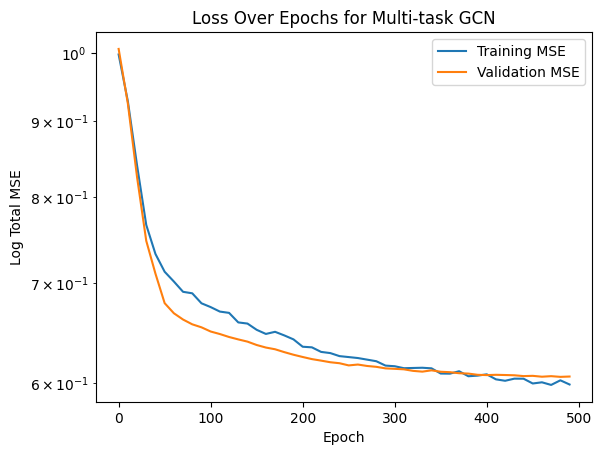

Epoch 000 | Train: 1.0141 | Val: 1.0314 * NEW BEST
Epoch 010 | Train: 1.0134 | Val: 1.0294 * NEW BEST
Epoch 020 | Train: 1.0111 | Val: 1.0273 * NEW BEST
Epoch 030 | Train: 1.0092 | Val: 1.0253 * NEW BEST
Epoch 040 | Train: 1.0074 | Val: 1.0233 * NEW BEST
Epoch 050 | Train: 1.0052 | Val: 1.0214 * NEW BEST
Epoch 060 | Train: 1.0040 | Val: 1.0194 * NEW BEST
Epoch 070 | Train: 1.0024 | Val: 1.0175 * NEW BEST
Epoch 080 | Train: 0.9999 | Val: 1.0156 * NEW BEST
Epoch 090 | Train: 0.9984 | Val: 1.0136 * NEW BEST
Epoch 100 | Train: 0.9973 | Val: 1.0117 * NEW BEST
Epoch 110 | Train: 0.9946 | Val: 1.0098 * NEW BEST
Epoch 120 | Train: 0.9924 | Val: 1.0079 * NEW BEST
Epoch 130 | Train: 0.9911 | Val: 1.0059 * NEW BEST
Epoch 140 | Train: 0.9892 | Val: 1.0040 * NEW BEST
Epoch 150 | Train: 0.9878 | Val: 1.0020 * NEW BEST
Epoch 160 | Train: 0.9858 | Val: 1.0001 * NEW BEST
Epoch 170 | Train: 0.9840 | Val: 0.9981 * NEW BEST
Epoch 180 | Train: 0.9824 | Val: 0.9961 * NEW BEST
Epoch 190 | Train: 0.9803 | Val

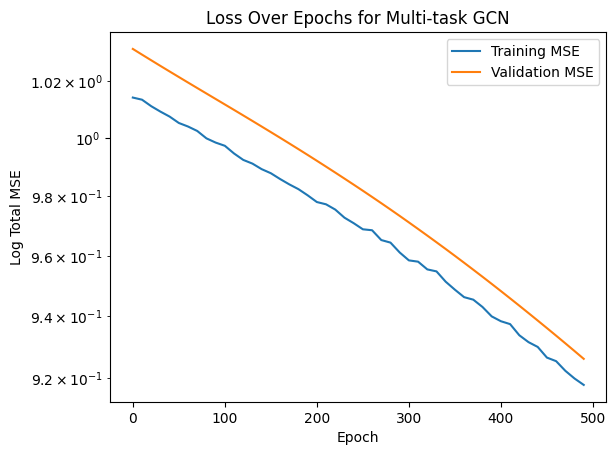

Epoch 000 | Train: 0.9933 | Val: 1.0024 * NEW BEST
Epoch 010 | Train: 0.9910 | Val: 1.0006 * NEW BEST
Epoch 020 | Train: 0.9909 | Val: 0.9989 * NEW BEST
Epoch 030 | Train: 0.9881 | Val: 0.9972 * NEW BEST
Epoch 040 | Train: 0.9874 | Val: 0.9955 * NEW BEST
Epoch 050 | Train: 0.9863 | Val: 0.9937 * NEW BEST
Epoch 060 | Train: 0.9839 | Val: 0.9920 * NEW BEST
Epoch 070 | Train: 0.9833 | Val: 0.9903 * NEW BEST
Epoch 080 | Train: 0.9810 | Val: 0.9886 * NEW BEST
Epoch 090 | Train: 0.9783 | Val: 0.9869 * NEW BEST
Epoch 100 | Train: 0.9783 | Val: 0.9851 * NEW BEST
Epoch 110 | Train: 0.9751 | Val: 0.9834 * NEW BEST
Epoch 120 | Train: 0.9756 | Val: 0.9817 * NEW BEST
Epoch 130 | Train: 0.9738 | Val: 0.9799 * NEW BEST
Epoch 140 | Train: 0.9724 | Val: 0.9782 * NEW BEST
Epoch 150 | Train: 0.9710 | Val: 0.9764 * NEW BEST
Epoch 160 | Train: 0.9677 | Val: 0.9746 * NEW BEST
Epoch 170 | Train: 0.9663 | Val: 0.9728 * NEW BEST
Epoch 180 | Train: 0.9652 | Val: 0.9710 * NEW BEST
Epoch 190 | Train: 0.9636 | Val

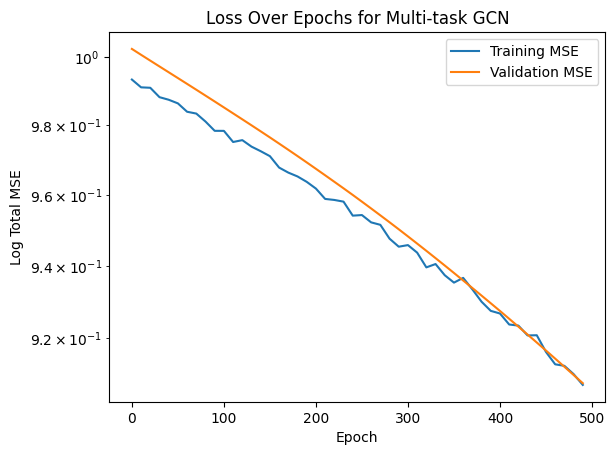

Epoch 000 | Train: 1.0049 | Val: 1.0162 * NEW BEST
Epoch 010 | Train: 1.0060 | Val: 1.0148 * NEW BEST
Epoch 020 | Train: 1.0036 | Val: 1.0133 * NEW BEST
Epoch 030 | Train: 1.0024 | Val: 1.0119 * NEW BEST
Epoch 040 | Train: 1.0000 | Val: 1.0105 * NEW BEST
Epoch 050 | Train: 0.9968 | Val: 1.0091 * NEW BEST
Epoch 060 | Train: 0.9982 | Val: 1.0077 * NEW BEST
Epoch 070 | Train: 0.9970 | Val: 1.0063 * NEW BEST
Epoch 080 | Train: 0.9932 | Val: 1.0049 * NEW BEST
Epoch 090 | Train: 0.9949 | Val: 1.0035 * NEW BEST
Epoch 100 | Train: 0.9910 | Val: 1.0021 * NEW BEST
Epoch 110 | Train: 0.9898 | Val: 1.0007 * NEW BEST
Epoch 120 | Train: 0.9905 | Val: 0.9993 * NEW BEST
Epoch 130 | Train: 0.9906 | Val: 0.9978 * NEW BEST
Epoch 140 | Train: 0.9877 | Val: 0.9964 * NEW BEST
Epoch 150 | Train: 0.9850 | Val: 0.9950 * NEW BEST
Epoch 160 | Train: 0.9839 | Val: 0.9935 * NEW BEST
Epoch 170 | Train: 0.9812 | Val: 0.9920 * NEW BEST
Epoch 180 | Train: 0.9807 | Val: 0.9906 * NEW BEST
Epoch 190 | Train: 0.9790 | Val

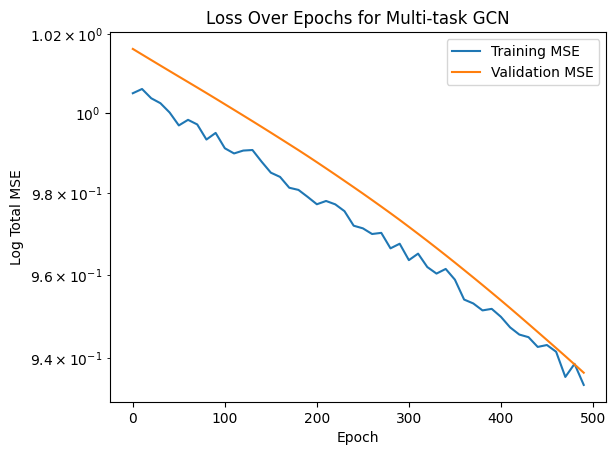

Epoch 000 | Train: 0.9924 | Val: 1.0063 * NEW BEST
Epoch 010 | Train: 0.9931 | Val: 1.0047 * NEW BEST
Epoch 020 | Train: 0.9905 | Val: 1.0032 * NEW BEST
Epoch 030 | Train: 0.9919 | Val: 1.0017 * NEW BEST
Epoch 040 | Train: 0.9887 | Val: 1.0002 * NEW BEST
Epoch 050 | Train: 0.9851 | Val: 0.9987 * NEW BEST
Epoch 060 | Train: 0.9844 | Val: 0.9972 * NEW BEST
Epoch 070 | Train: 0.9874 | Val: 0.9958 * NEW BEST
Epoch 080 | Train: 0.9821 | Val: 0.9943 * NEW BEST
Epoch 090 | Train: 0.9810 | Val: 0.9929 * NEW BEST
Epoch 100 | Train: 0.9810 | Val: 0.9914 * NEW BEST
Epoch 110 | Train: 0.9792 | Val: 0.9900 * NEW BEST
Epoch 120 | Train: 0.9761 | Val: 0.9885 * NEW BEST
Epoch 130 | Train: 0.9768 | Val: 0.9871 * NEW BEST
Epoch 140 | Train: 0.9735 | Val: 0.9856 * NEW BEST
Epoch 150 | Train: 0.9731 | Val: 0.9842 * NEW BEST
Epoch 160 | Train: 0.9733 | Val: 0.9827 * NEW BEST
Epoch 170 | Train: 0.9723 | Val: 0.9812 * NEW BEST
Epoch 180 | Train: 0.9720 | Val: 0.9798 * NEW BEST
Epoch 190 | Train: 0.9684 | Val

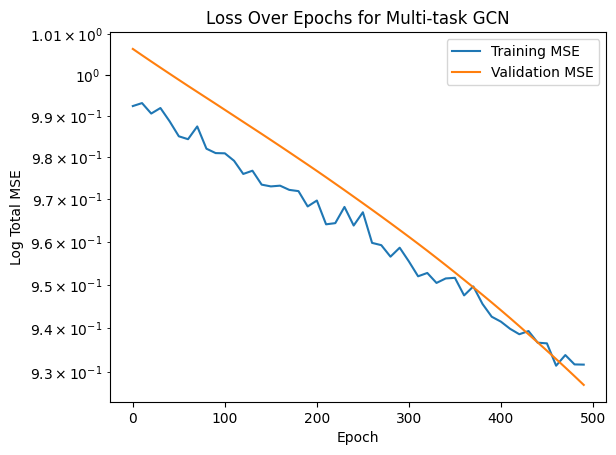

Epoch 000 | Train: 0.9956 | Val: 1.0044 * NEW BEST
Epoch 010 | Train: 0.9933 | Val: 1.0017 * NEW BEST
Epoch 020 | Train: 0.9907 | Val: 0.9990 * NEW BEST
Epoch 030 | Train: 0.9879 | Val: 0.9964 * NEW BEST
Epoch 040 | Train: 0.9858 | Val: 0.9938 * NEW BEST
Epoch 050 | Train: 0.9829 | Val: 0.9911 * NEW BEST
Epoch 060 | Train: 0.9804 | Val: 0.9884 * NEW BEST
Epoch 070 | Train: 0.9780 | Val: 0.9858 * NEW BEST
Epoch 080 | Train: 0.9752 | Val: 0.9831 * NEW BEST
Epoch 090 | Train: 0.9733 | Val: 0.9803 * NEW BEST
Epoch 100 | Train: 0.9697 | Val: 0.9775 * NEW BEST
Epoch 110 | Train: 0.9677 | Val: 0.9747 * NEW BEST
Epoch 120 | Train: 0.9646 | Val: 0.9719 * NEW BEST
Epoch 130 | Train: 0.9620 | Val: 0.9690 * NEW BEST
Epoch 140 | Train: 0.9595 | Val: 0.9660 * NEW BEST
Epoch 150 | Train: 0.9564 | Val: 0.9630 * NEW BEST
Epoch 160 | Train: 0.9541 | Val: 0.9599 * NEW BEST
Epoch 170 | Train: 0.9503 | Val: 0.9567 * NEW BEST
Epoch 180 | Train: 0.9472 | Val: 0.9535 * NEW BEST
Epoch 190 | Train: 0.9447 | Val

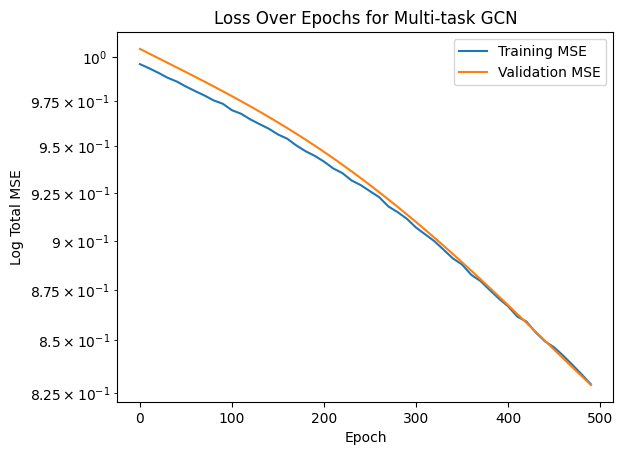

Epoch 000 | Train: 1.0155 | Val: 1.0388 * NEW BEST
Epoch 010 | Train: 1.0132 | Val: 1.0356 * NEW BEST
Epoch 020 | Train: 1.0098 | Val: 1.0325 * NEW BEST
Epoch 030 | Train: 1.0067 | Val: 1.0295 * NEW BEST
Epoch 040 | Train: 1.0043 | Val: 1.0265 * NEW BEST
Epoch 050 | Train: 1.0010 | Val: 1.0236 * NEW BEST
Epoch 060 | Train: 0.9973 | Val: 1.0207 * NEW BEST
Epoch 070 | Train: 0.9954 | Val: 1.0178 * NEW BEST
Epoch 080 | Train: 0.9938 | Val: 1.0149 * NEW BEST
Epoch 090 | Train: 0.9901 | Val: 1.0121 * NEW BEST
Epoch 100 | Train: 0.9889 | Val: 1.0092 * NEW BEST
Epoch 110 | Train: 0.9870 | Val: 1.0063 * NEW BEST
Epoch 120 | Train: 0.9835 | Val: 1.0035 * NEW BEST
Epoch 130 | Train: 0.9812 | Val: 1.0006 * NEW BEST
Epoch 140 | Train: 0.9777 | Val: 0.9977 * NEW BEST
Epoch 150 | Train: 0.9750 | Val: 0.9947 * NEW BEST
Epoch 160 | Train: 0.9728 | Val: 0.9918 * NEW BEST
Epoch 170 | Train: 0.9695 | Val: 0.9888 * NEW BEST
Epoch 180 | Train: 0.9665 | Val: 0.9857 * NEW BEST
Epoch 190 | Train: 0.9640 | Val

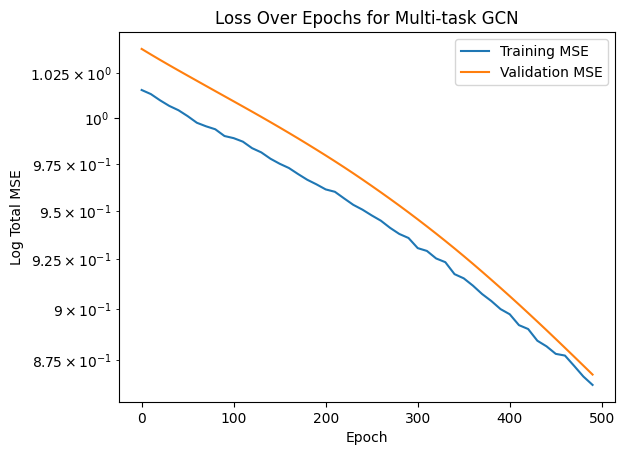

Epoch 000 | Train: 0.9940 | Val: 1.0090 * NEW BEST
Epoch 010 | Train: 0.9928 | Val: 1.0057 * NEW BEST
Epoch 020 | Train: 0.9895 | Val: 1.0024 * NEW BEST
Epoch 030 | Train: 0.9845 | Val: 0.9992 * NEW BEST
Epoch 040 | Train: 0.9833 | Val: 0.9960 * NEW BEST
Epoch 050 | Train: 0.9802 | Val: 0.9929 * NEW BEST
Epoch 060 | Train: 0.9780 | Val: 0.9897 * NEW BEST
Epoch 070 | Train: 0.9763 | Val: 0.9866 * NEW BEST
Epoch 080 | Train: 0.9734 | Val: 0.9835 * NEW BEST
Epoch 090 | Train: 0.9688 | Val: 0.9804 * NEW BEST
Epoch 100 | Train: 0.9662 | Val: 0.9773 * NEW BEST
Epoch 110 | Train: 0.9644 | Val: 0.9742 * NEW BEST
Epoch 120 | Train: 0.9620 | Val: 0.9711 * NEW BEST
Epoch 130 | Train: 0.9588 | Val: 0.9680 * NEW BEST
Epoch 140 | Train: 0.9575 | Val: 0.9649 * NEW BEST
Epoch 150 | Train: 0.9557 | Val: 0.9617 * NEW BEST
Epoch 160 | Train: 0.9518 | Val: 0.9585 * NEW BEST
Epoch 170 | Train: 0.9473 | Val: 0.9553 * NEW BEST
Epoch 180 | Train: 0.9470 | Val: 0.9521 * NEW BEST
Epoch 190 | Train: 0.9462 | Val

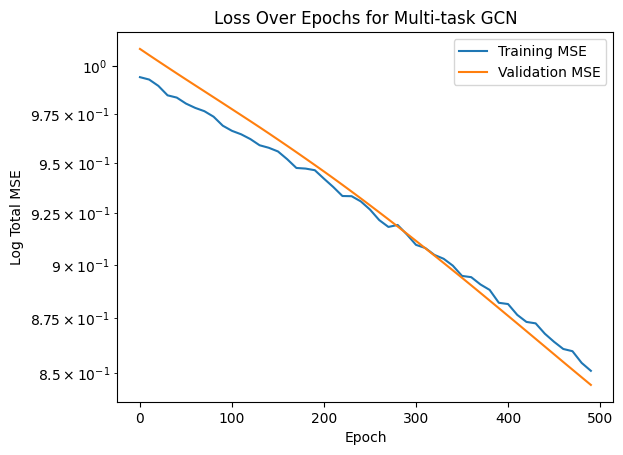

Epoch 000 | Train: 1.0018 | Val: 1.0087 * NEW BEST
Epoch 010 | Train: 0.9992 | Val: 1.0059 * NEW BEST
Epoch 020 | Train: 0.9969 | Val: 1.0032 * NEW BEST
Epoch 030 | Train: 0.9950 | Val: 1.0005 * NEW BEST
Epoch 040 | Train: 0.9908 | Val: 0.9978 * NEW BEST
Epoch 050 | Train: 0.9873 | Val: 0.9952 * NEW BEST
Epoch 060 | Train: 0.9879 | Val: 0.9926 * NEW BEST
Epoch 070 | Train: 0.9835 | Val: 0.9900 * NEW BEST
Epoch 080 | Train: 0.9812 | Val: 0.9875 * NEW BEST
Epoch 090 | Train: 0.9811 | Val: 0.9849 * NEW BEST
Epoch 100 | Train: 0.9748 | Val: 0.9824 * NEW BEST
Epoch 110 | Train: 0.9752 | Val: 0.9798 * NEW BEST
Epoch 120 | Train: 0.9721 | Val: 0.9773 * NEW BEST
Epoch 130 | Train: 0.9731 | Val: 0.9747 * NEW BEST
Epoch 140 | Train: 0.9680 | Val: 0.9721 * NEW BEST
Epoch 150 | Train: 0.9696 | Val: 0.9695 * NEW BEST
Epoch 160 | Train: 0.9659 | Val: 0.9669 * NEW BEST
Epoch 170 | Train: 0.9659 | Val: 0.9642 * NEW BEST
Epoch 180 | Train: 0.9613 | Val: 0.9615 * NEW BEST
Epoch 190 | Train: 0.9548 | Val

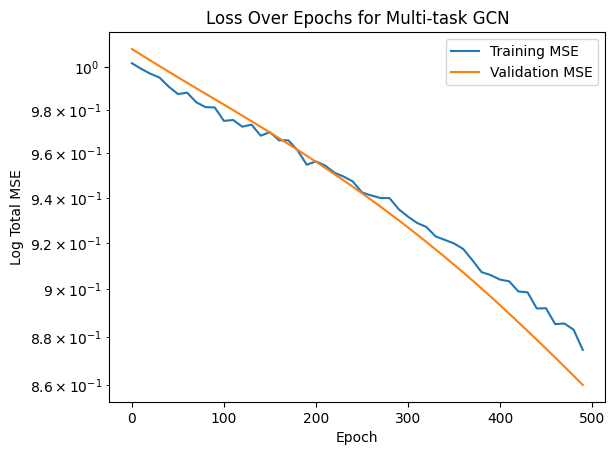

Epoch 000 | Train: 0.9839 | Val: 1.0000 * NEW BEST
Epoch 010 | Train: 0.9793 | Val: 0.9949 * NEW BEST
Epoch 020 | Train: 0.9752 | Val: 0.9898 * NEW BEST
Epoch 030 | Train: 0.9710 | Val: 0.9849 * NEW BEST
Epoch 040 | Train: 0.9664 | Val: 0.9799 * NEW BEST
Epoch 050 | Train: 0.9622 | Val: 0.9749 * NEW BEST
Epoch 060 | Train: 0.9582 | Val: 0.9699 * NEW BEST
Epoch 070 | Train: 0.9534 | Val: 0.9648 * NEW BEST
Epoch 080 | Train: 0.9489 | Val: 0.9596 * NEW BEST
Epoch 090 | Train: 0.9437 | Val: 0.9543 * NEW BEST
Epoch 100 | Train: 0.9392 | Val: 0.9489 * NEW BEST
Epoch 110 | Train: 0.9336 | Val: 0.9433 * NEW BEST
Epoch 120 | Train: 0.9294 | Val: 0.9376 * NEW BEST
Epoch 130 | Train: 0.9235 | Val: 0.9317 * NEW BEST
Epoch 140 | Train: 0.9181 | Val: 0.9257 * NEW BEST
Epoch 150 | Train: 0.9125 | Val: 0.9195 * NEW BEST
Epoch 160 | Train: 0.9072 | Val: 0.9132 * NEW BEST
Epoch 170 | Train: 0.9014 | Val: 0.9067 * NEW BEST
Epoch 180 | Train: 0.8955 | Val: 0.9001 * NEW BEST
Epoch 190 | Train: 0.8885 | Val

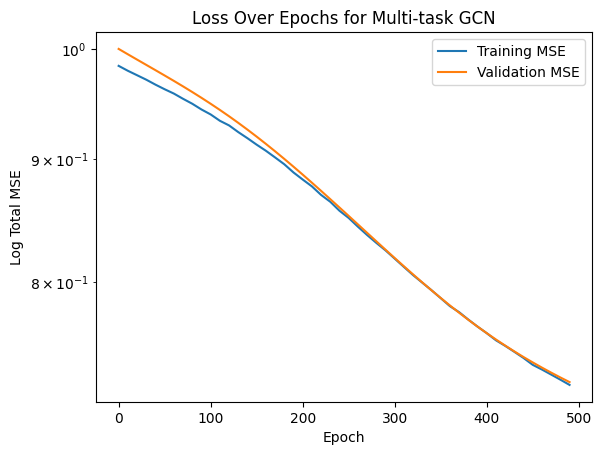

Epoch 000 | Train: 1.0074 | Val: 1.0251 * NEW BEST
Epoch 010 | Train: 1.0023 | Val: 1.0196 * NEW BEST
Epoch 020 | Train: 0.9974 | Val: 1.0142 * NEW BEST
Epoch 030 | Train: 0.9936 | Val: 1.0088 * NEW BEST
Epoch 040 | Train: 0.9886 | Val: 1.0036 * NEW BEST
Epoch 050 | Train: 0.9863 | Val: 0.9985 * NEW BEST
Epoch 060 | Train: 0.9809 | Val: 0.9934 * NEW BEST
Epoch 070 | Train: 0.9757 | Val: 0.9882 * NEW BEST
Epoch 080 | Train: 0.9698 | Val: 0.9831 * NEW BEST
Epoch 090 | Train: 0.9655 | Val: 0.9778 * NEW BEST
Epoch 100 | Train: 0.9616 | Val: 0.9726 * NEW BEST
Epoch 110 | Train: 0.9573 | Val: 0.9671 * NEW BEST
Epoch 120 | Train: 0.9507 | Val: 0.9616 * NEW BEST
Epoch 130 | Train: 0.9464 | Val: 0.9560 * NEW BEST
Epoch 140 | Train: 0.9406 | Val: 0.9501 * NEW BEST
Epoch 150 | Train: 0.9366 | Val: 0.9441 * NEW BEST
Epoch 160 | Train: 0.9305 | Val: 0.9379 * NEW BEST
Epoch 170 | Train: 0.9245 | Val: 0.9316 * NEW BEST
Epoch 180 | Train: 0.9196 | Val: 0.9250 * NEW BEST
Epoch 190 | Train: 0.9124 | Val

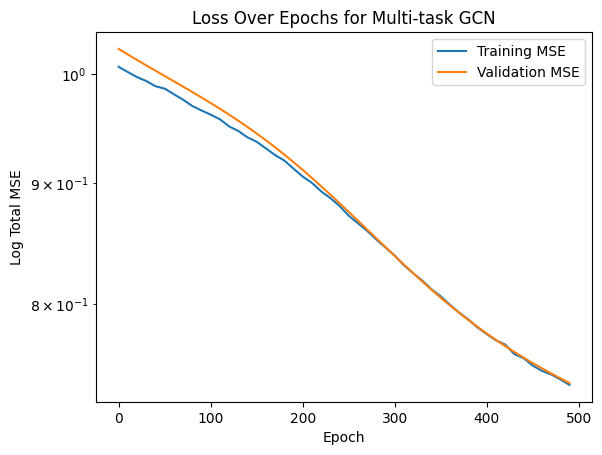

Epoch 000 | Train: 0.9912 | Val: 1.0011 * NEW BEST
Epoch 010 | Train: 0.9860 | Val: 0.9960 * NEW BEST
Epoch 020 | Train: 0.9830 | Val: 0.9910 * NEW BEST
Epoch 030 | Train: 0.9785 | Val: 0.9862 * NEW BEST
Epoch 040 | Train: 0.9753 | Val: 0.9813 * NEW BEST
Epoch 050 | Train: 0.9696 | Val: 0.9766 * NEW BEST
Epoch 060 | Train: 0.9649 | Val: 0.9718 * NEW BEST
Epoch 070 | Train: 0.9614 | Val: 0.9670 * NEW BEST
Epoch 080 | Train: 0.9570 | Val: 0.9622 * NEW BEST
Epoch 090 | Train: 0.9532 | Val: 0.9573 * NEW BEST
Epoch 100 | Train: 0.9493 | Val: 0.9523 * NEW BEST
Epoch 110 | Train: 0.9448 | Val: 0.9472 * NEW BEST
Epoch 120 | Train: 0.9397 | Val: 0.9420 * NEW BEST
Epoch 130 | Train: 0.9375 | Val: 0.9367 * NEW BEST
Epoch 140 | Train: 0.9303 | Val: 0.9312 * NEW BEST
Epoch 150 | Train: 0.9259 | Val: 0.9256 * NEW BEST
Epoch 160 | Train: 0.9209 | Val: 0.9199 * NEW BEST
Epoch 170 | Train: 0.9157 | Val: 0.9140 * NEW BEST
Epoch 180 | Train: 0.9096 | Val: 0.9079 * NEW BEST
Epoch 190 | Train: 0.9056 | Val

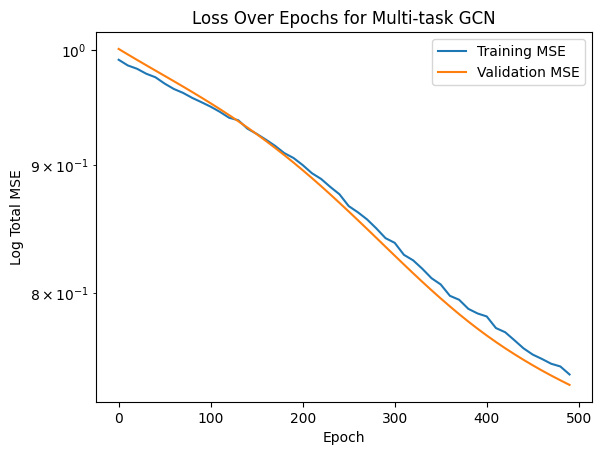

Epoch 000 | Train: 0.9979 | Val: 1.0043 * NEW BEST
Epoch 010 | Train: 0.9940 | Val: 0.9997 * NEW BEST
Epoch 020 | Train: 0.9914 | Val: 0.9952 * NEW BEST
Epoch 030 | Train: 0.9877 | Val: 0.9907 * NEW BEST
Epoch 040 | Train: 0.9791 | Val: 0.9863 * NEW BEST
Epoch 050 | Train: 0.9761 | Val: 0.9818 * NEW BEST
Epoch 060 | Train: 0.9719 | Val: 0.9774 * NEW BEST
Epoch 070 | Train: 0.9684 | Val: 0.9729 * NEW BEST
Epoch 080 | Train: 0.9632 | Val: 0.9683 * NEW BEST
Epoch 090 | Train: 0.9606 | Val: 0.9636 * NEW BEST
Epoch 100 | Train: 0.9560 | Val: 0.9589 * NEW BEST
Epoch 110 | Train: 0.9525 | Val: 0.9541 * NEW BEST
Epoch 120 | Train: 0.9475 | Val: 0.9492 * NEW BEST
Epoch 130 | Train: 0.9426 | Val: 0.9441 * NEW BEST
Epoch 140 | Train: 0.9392 | Val: 0.9390 * NEW BEST
Epoch 150 | Train: 0.9328 | Val: 0.9336 * NEW BEST
Epoch 160 | Train: 0.9277 | Val: 0.9282 * NEW BEST
Epoch 170 | Train: 0.9250 | Val: 0.9226 * NEW BEST
Epoch 180 | Train: 0.9209 | Val: 0.9169 * NEW BEST
Epoch 190 | Train: 0.9137 | Val

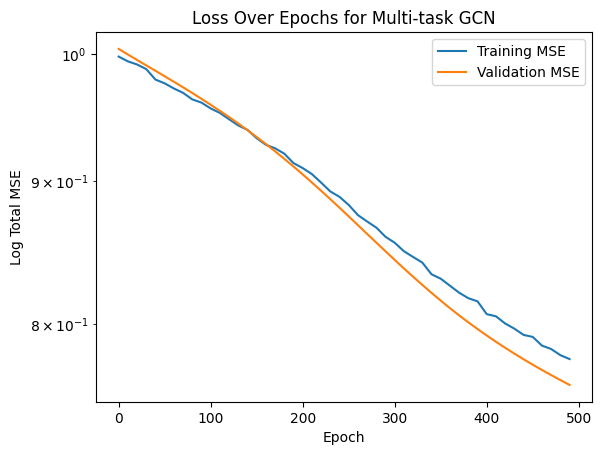

Epoch 000 | Train: 1.0273 | Val: 1.0426 * NEW BEST
Epoch 010 | Train: 1.0266 | Val: 1.0422 * NEW BEST
Epoch 020 | Train: 1.0255 | Val: 1.0418 * NEW BEST
Epoch 030 | Train: 1.0261 | Val: 1.0414 * NEW BEST
Epoch 040 | Train: 1.0258 | Val: 1.0410 * NEW BEST
Epoch 050 | Train: 1.0244 | Val: 1.0406 * NEW BEST
Epoch 060 | Train: 1.0254 | Val: 1.0402 * NEW BEST
Epoch 070 | Train: 1.0246 | Val: 1.0398 * NEW BEST
Epoch 080 | Train: 1.0237 | Val: 1.0394 * NEW BEST
Epoch 090 | Train: 1.0242 | Val: 1.0390 * NEW BEST
Epoch 100 | Train: 1.0224 | Val: 1.0386 * NEW BEST
Epoch 110 | Train: 1.0232 | Val: 1.0382 * NEW BEST
Epoch 120 | Train: 1.0225 | Val: 1.0378 * NEW BEST
Epoch 130 | Train: 1.0230 | Val: 1.0374 * NEW BEST
Epoch 140 | Train: 1.0216 | Val: 1.0370 * NEW BEST
Epoch 150 | Train: 1.0206 | Val: 1.0366 * NEW BEST
Epoch 160 | Train: 1.0232 | Val: 1.0363 * NEW BEST
Epoch 170 | Train: 1.0206 | Val: 1.0359 * NEW BEST
Epoch 180 | Train: 1.0200 | Val: 1.0355 * NEW BEST
Epoch 190 | Train: 1.0203 | Val

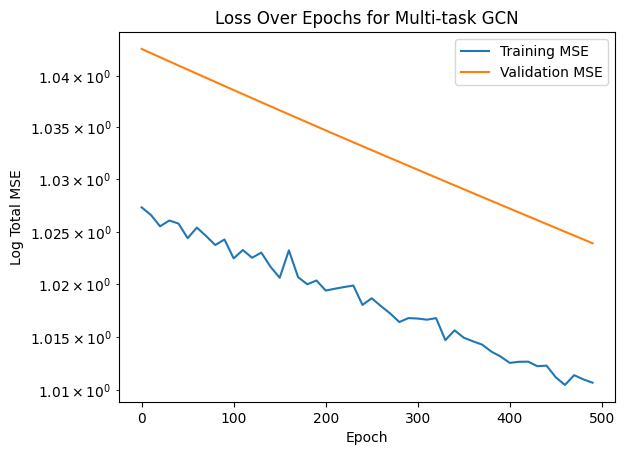

Epoch 000 | Train: 0.9972 | Val: 1.0026 * NEW BEST
Epoch 010 | Train: 0.9982 | Val: 1.0022 * NEW BEST
Epoch 020 | Train: 0.9958 | Val: 1.0019 * NEW BEST
Epoch 030 | Train: 0.9970 | Val: 1.0015 * NEW BEST
Epoch 040 | Train: 0.9967 | Val: 1.0012 * NEW BEST
Epoch 050 | Train: 0.9968 | Val: 1.0009 * NEW BEST
Epoch 060 | Train: 0.9960 | Val: 1.0005 * NEW BEST
Epoch 070 | Train: 0.9965 | Val: 1.0002 * NEW BEST
Epoch 080 | Train: 0.9957 | Val: 0.9998 * NEW BEST
Epoch 090 | Train: 0.9950 | Val: 0.9995 * NEW BEST
Epoch 100 | Train: 0.9960 | Val: 0.9992 * NEW BEST
Epoch 110 | Train: 0.9959 | Val: 0.9988 * NEW BEST
Epoch 120 | Train: 0.9935 | Val: 0.9985 * NEW BEST
Epoch 130 | Train: 0.9932 | Val: 0.9982 * NEW BEST
Epoch 140 | Train: 0.9939 | Val: 0.9978 * NEW BEST
Epoch 150 | Train: 0.9936 | Val: 0.9975 * NEW BEST
Epoch 160 | Train: 0.9928 | Val: 0.9972 * NEW BEST
Epoch 170 | Train: 0.9916 | Val: 0.9968 * NEW BEST
Epoch 180 | Train: 0.9908 | Val: 0.9965 * NEW BEST
Epoch 190 | Train: 0.9916 | Val

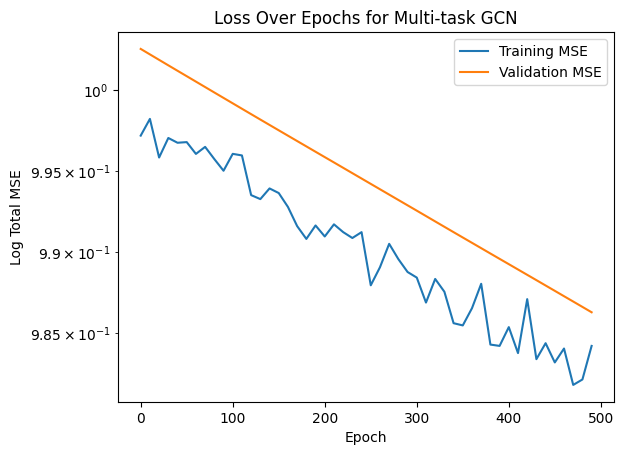

Epoch 000 | Train: 1.0052 | Val: 1.0269 * NEW BEST
Epoch 010 | Train: 1.0056 | Val: 1.0267 * NEW BEST
Epoch 020 | Train: 1.0035 | Val: 1.0264 * NEW BEST
Epoch 030 | Train: 1.0041 | Val: 1.0261 * NEW BEST
Epoch 040 | Train: 1.0045 | Val: 1.0258 * NEW BEST
Epoch 050 | Train: 1.0045 | Val: 1.0255 * NEW BEST
Epoch 060 | Train: 1.0020 | Val: 1.0253 * NEW BEST
Epoch 070 | Train: 1.0036 | Val: 1.0250 * NEW BEST
Epoch 080 | Train: 1.0021 | Val: 1.0247 * NEW BEST
Epoch 090 | Train: 1.0040 | Val: 1.0244 * NEW BEST
Epoch 100 | Train: 1.0022 | Val: 1.0242 * NEW BEST
Epoch 110 | Train: 1.0032 | Val: 1.0239 * NEW BEST
Epoch 120 | Train: 1.0020 | Val: 1.0236 * NEW BEST
Epoch 130 | Train: 1.0000 | Val: 1.0233 * NEW BEST
Epoch 140 | Train: 1.0019 | Val: 1.0230 * NEW BEST
Epoch 150 | Train: 1.0008 | Val: 1.0228 * NEW BEST
Epoch 160 | Train: 1.0021 | Val: 1.0225 * NEW BEST
Epoch 170 | Train: 1.0012 | Val: 1.0222 * NEW BEST
Epoch 180 | Train: 1.0001 | Val: 1.0219 * NEW BEST
Epoch 190 | Train: 0.9998 | Val

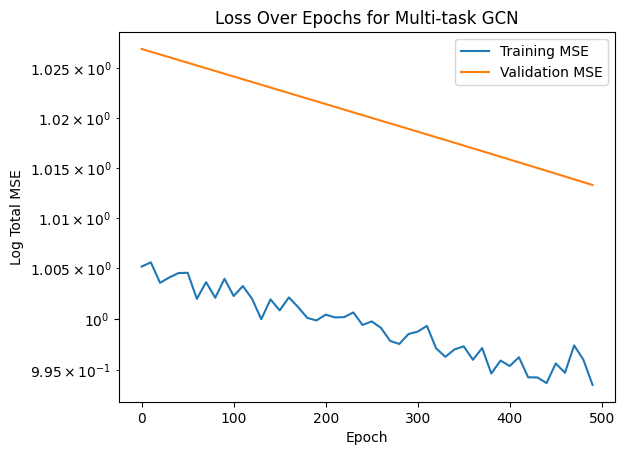

Epoch 000 | Train: 1.0189 | Val: 1.0167 * NEW BEST
Epoch 010 | Train: 1.0191 | Val: 1.0164 * NEW BEST
Epoch 020 | Train: 1.0197 | Val: 1.0160 * NEW BEST
Epoch 030 | Train: 1.0230 | Val: 1.0157 * NEW BEST
Epoch 040 | Train: 1.0199 | Val: 1.0154 * NEW BEST
Epoch 050 | Train: 1.0193 | Val: 1.0151 * NEW BEST
Epoch 060 | Train: 1.0184 | Val: 1.0147 * NEW BEST
Epoch 070 | Train: 1.0134 | Val: 1.0144 * NEW BEST
Epoch 080 | Train: 1.0164 | Val: 1.0141 * NEW BEST
Epoch 090 | Train: 1.0176 | Val: 1.0138 * NEW BEST
Epoch 100 | Train: 1.0174 | Val: 1.0135 * NEW BEST
Epoch 110 | Train: 1.0167 | Val: 1.0131 * NEW BEST
Epoch 120 | Train: 1.0167 | Val: 1.0128 * NEW BEST
Epoch 130 | Train: 1.0150 | Val: 1.0125 * NEW BEST
Epoch 140 | Train: 1.0173 | Val: 1.0122 * NEW BEST
Epoch 150 | Train: 1.0147 | Val: 1.0119 * NEW BEST
Epoch 160 | Train: 1.0105 | Val: 1.0116 * NEW BEST
Epoch 170 | Train: 1.0128 | Val: 1.0113 * NEW BEST
Epoch 180 | Train: 1.0145 | Val: 1.0110 * NEW BEST
Epoch 190 | Train: 1.0144 | Val

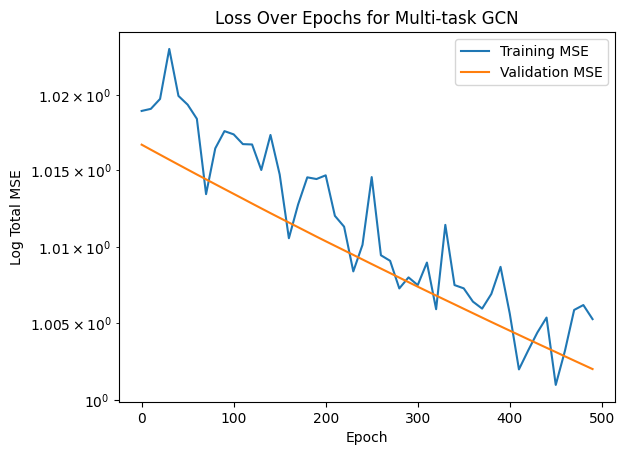

Epoch 000 | Train: 0.9991 | Val: 1.0121 * NEW BEST
Epoch 010 | Train: 0.9989 | Val: 1.0115 * NEW BEST
Epoch 020 | Train: 0.9982 | Val: 1.0109 * NEW BEST
Epoch 030 | Train: 0.9972 | Val: 1.0103 * NEW BEST
Epoch 040 | Train: 0.9975 | Val: 1.0097 * NEW BEST
Epoch 050 | Train: 0.9966 | Val: 1.0091 * NEW BEST
Epoch 060 | Train: 0.9961 | Val: 1.0085 * NEW BEST
Epoch 070 | Train: 0.9949 | Val: 1.0079 * NEW BEST
Epoch 080 | Train: 0.9959 | Val: 1.0073 * NEW BEST
Epoch 090 | Train: 0.9945 | Val: 1.0067 * NEW BEST
Epoch 100 | Train: 0.9935 | Val: 1.0061 * NEW BEST
Epoch 110 | Train: 0.9932 | Val: 1.0055 * NEW BEST
Epoch 120 | Train: 0.9927 | Val: 1.0049 * NEW BEST
Epoch 130 | Train: 0.9920 | Val: 1.0043 * NEW BEST
Epoch 140 | Train: 0.9923 | Val: 1.0037 * NEW BEST
Epoch 150 | Train: 0.9913 | Val: 1.0031 * NEW BEST
Epoch 160 | Train: 0.9905 | Val: 1.0025 * NEW BEST
Epoch 170 | Train: 0.9894 | Val: 1.0019 * NEW BEST
Epoch 180 | Train: 0.9896 | Val: 1.0013 * NEW BEST
Epoch 190 | Train: 0.9891 | Val

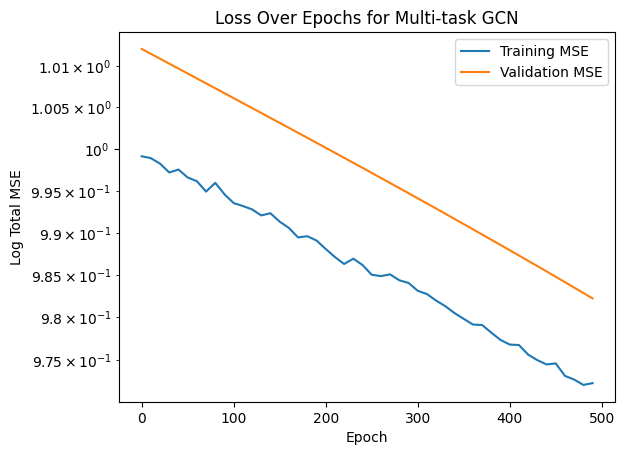

Epoch 000 | Train: 1.0071 | Val: 1.0259 * NEW BEST
Epoch 010 | Train: 1.0068 | Val: 1.0252 * NEW BEST
Epoch 020 | Train: 1.0065 | Val: 1.0246 * NEW BEST
Epoch 030 | Train: 1.0038 | Val: 1.0239 * NEW BEST
Epoch 040 | Train: 1.0028 | Val: 1.0232 * NEW BEST
Epoch 050 | Train: 1.0035 | Val: 1.0226 * NEW BEST
Epoch 060 | Train: 1.0038 | Val: 1.0219 * NEW BEST
Epoch 070 | Train: 1.0034 | Val: 1.0213 * NEW BEST
Epoch 080 | Train: 1.0013 | Val: 1.0206 * NEW BEST
Epoch 090 | Train: 1.0017 | Val: 1.0199 * NEW BEST
Epoch 100 | Train: 1.0010 | Val: 1.0193 * NEW BEST
Epoch 110 | Train: 1.0022 | Val: 1.0186 * NEW BEST
Epoch 120 | Train: 0.9998 | Val: 1.0180 * NEW BEST
Epoch 130 | Train: 1.0004 | Val: 1.0173 * NEW BEST
Epoch 140 | Train: 1.0001 | Val: 1.0167 * NEW BEST
Epoch 150 | Train: 0.9974 | Val: 1.0160 * NEW BEST
Epoch 160 | Train: 0.9973 | Val: 1.0154 * NEW BEST
Epoch 170 | Train: 0.9986 | Val: 1.0147 * NEW BEST
Epoch 180 | Train: 0.9965 | Val: 1.0141 * NEW BEST
Epoch 190 | Train: 0.9957 | Val

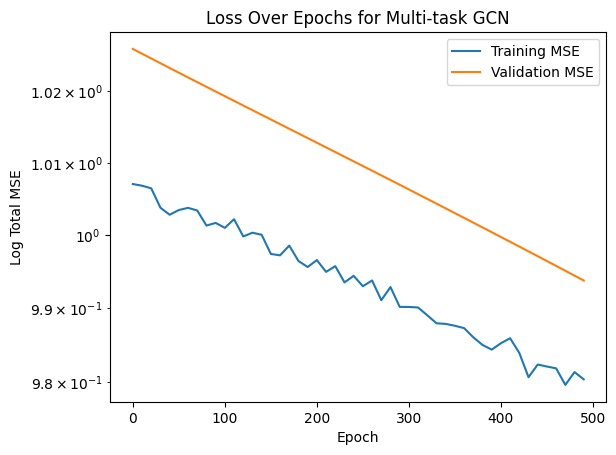

Epoch 000 | Train: 0.9928 | Val: 1.0135 * NEW BEST
Epoch 010 | Train: 0.9911 | Val: 1.0129 * NEW BEST
Epoch 020 | Train: 0.9926 | Val: 1.0122 * NEW BEST
Epoch 030 | Train: 0.9916 | Val: 1.0116 * NEW BEST
Epoch 040 | Train: 0.9930 | Val: 1.0110 * NEW BEST
Epoch 050 | Train: 0.9896 | Val: 1.0104 * NEW BEST
Epoch 060 | Train: 0.9896 | Val: 1.0097 * NEW BEST
Epoch 070 | Train: 0.9875 | Val: 1.0091 * NEW BEST
Epoch 080 | Train: 0.9890 | Val: 1.0085 * NEW BEST
Epoch 090 | Train: 0.9890 | Val: 1.0079 * NEW BEST
Epoch 100 | Train: 0.9874 | Val: 1.0073 * NEW BEST
Epoch 110 | Train: 0.9867 | Val: 1.0067 * NEW BEST
Epoch 120 | Train: 0.9855 | Val: 1.0061 * NEW BEST
Epoch 130 | Train: 0.9855 | Val: 1.0055 * NEW BEST
Epoch 140 | Train: 0.9870 | Val: 1.0049 * NEW BEST
Epoch 150 | Train: 0.9848 | Val: 1.0043 * NEW BEST
Epoch 160 | Train: 0.9842 | Val: 1.0037 * NEW BEST
Epoch 170 | Train: 0.9823 | Val: 1.0031 * NEW BEST
Epoch 180 | Train: 0.9851 | Val: 1.0025 * NEW BEST
Epoch 190 | Train: 0.9814 | Val

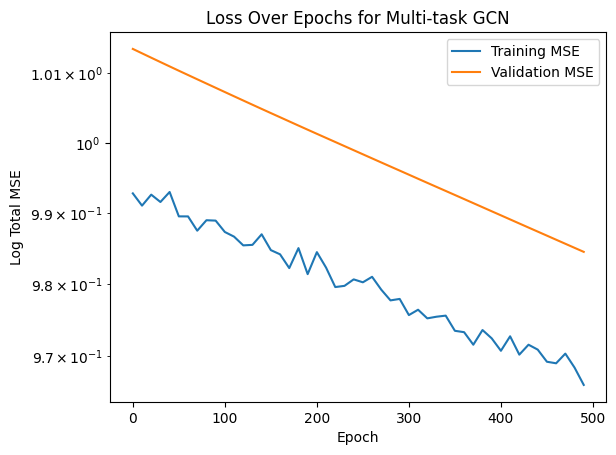

Epoch 000 | Train: 0.9978 | Val: 1.0059 * NEW BEST
Epoch 010 | Train: 0.9988 | Val: 1.0054 * NEW BEST
Epoch 020 | Train: 0.9998 | Val: 1.0050 * NEW BEST
Epoch 030 | Train: 0.9949 | Val: 1.0045 * NEW BEST
Epoch 040 | Train: 0.9963 | Val: 1.0040 * NEW BEST
Epoch 050 | Train: 0.9988 | Val: 1.0035 * NEW BEST
Epoch 060 | Train: 0.9945 | Val: 1.0031 * NEW BEST
Epoch 070 | Train: 0.9975 | Val: 1.0026 * NEW BEST
Epoch 080 | Train: 0.9964 | Val: 1.0021 * NEW BEST
Epoch 090 | Train: 0.9942 | Val: 1.0017 * NEW BEST
Epoch 100 | Train: 0.9945 | Val: 1.0012 * NEW BEST
Epoch 110 | Train: 0.9942 | Val: 1.0007 * NEW BEST
Epoch 120 | Train: 0.9920 | Val: 1.0003 * NEW BEST
Epoch 130 | Train: 0.9940 | Val: 0.9998 * NEW BEST
Epoch 140 | Train: 0.9923 | Val: 0.9994 * NEW BEST
Epoch 150 | Train: 0.9924 | Val: 0.9989 * NEW BEST
Epoch 160 | Train: 0.9920 | Val: 0.9984 * NEW BEST
Epoch 170 | Train: 0.9924 | Val: 0.9980 * NEW BEST
Epoch 180 | Train: 0.9936 | Val: 0.9975 * NEW BEST
Epoch 190 | Train: 0.9923 | Val

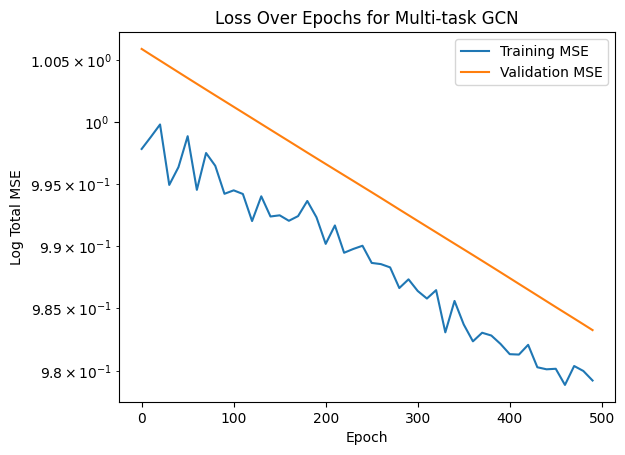

Epoch 000 | Train: 0.9939 | Val: 1.0092 * NEW BEST
Epoch 010 | Train: 0.9931 | Val: 1.0082 * NEW BEST
Epoch 020 | Train: 0.9921 | Val: 1.0073 * NEW BEST
Epoch 030 | Train: 0.9912 | Val: 1.0064 * NEW BEST
Epoch 040 | Train: 0.9908 | Val: 1.0055 * NEW BEST
Epoch 050 | Train: 0.9899 | Val: 1.0046 * NEW BEST
Epoch 060 | Train: 0.9889 | Val: 1.0036 * NEW BEST
Epoch 070 | Train: 0.9879 | Val: 1.0027 * NEW BEST
Epoch 080 | Train: 0.9869 | Val: 1.0018 * NEW BEST
Epoch 090 | Train: 0.9863 | Val: 1.0009 * NEW BEST
Epoch 100 | Train: 0.9853 | Val: 1.0000 * NEW BEST
Epoch 110 | Train: 0.9843 | Val: 0.9991 * NEW BEST
Epoch 120 | Train: 0.9833 | Val: 0.9982 * NEW BEST
Epoch 130 | Train: 0.9824 | Val: 0.9973 * NEW BEST
Epoch 140 | Train: 0.9816 | Val: 0.9964 * NEW BEST
Epoch 150 | Train: 0.9810 | Val: 0.9955 * NEW BEST
Epoch 160 | Train: 0.9801 | Val: 0.9945 * NEW BEST
Epoch 170 | Train: 0.9792 | Val: 0.9936 * NEW BEST
Epoch 180 | Train: 0.9786 | Val: 0.9927 * NEW BEST
Epoch 190 | Train: 0.9774 | Val

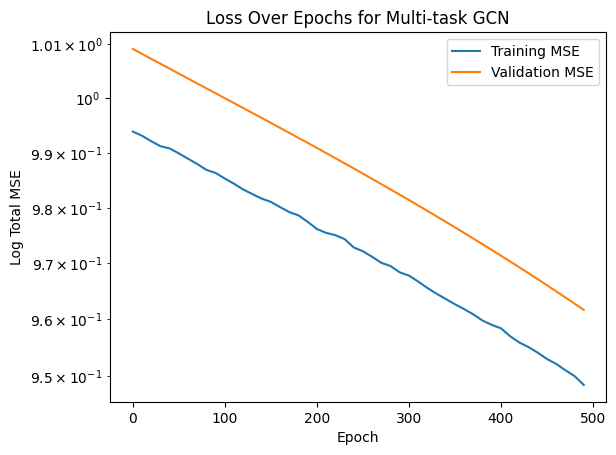

Epoch 000 | Train: 1.0041 | Val: 1.0145 * NEW BEST
Epoch 010 | Train: 1.0036 | Val: 1.0134 * NEW BEST
Epoch 020 | Train: 1.0023 | Val: 1.0122 * NEW BEST
Epoch 030 | Train: 1.0012 | Val: 1.0111 * NEW BEST
Epoch 040 | Train: 0.9998 | Val: 1.0100 * NEW BEST
Epoch 050 | Train: 0.9978 | Val: 1.0090 * NEW BEST
Epoch 060 | Train: 0.9976 | Val: 1.0079 * NEW BEST
Epoch 070 | Train: 0.9971 | Val: 1.0068 * NEW BEST
Epoch 080 | Train: 0.9962 | Val: 1.0057 * NEW BEST
Epoch 090 | Train: 0.9942 | Val: 1.0046 * NEW BEST
Epoch 100 | Train: 0.9939 | Val: 1.0035 * NEW BEST
Epoch 110 | Train: 0.9931 | Val: 1.0025 * NEW BEST
Epoch 120 | Train: 0.9920 | Val: 1.0014 * NEW BEST
Epoch 130 | Train: 0.9912 | Val: 1.0003 * NEW BEST
Epoch 140 | Train: 0.9899 | Val: 0.9993 * NEW BEST
Epoch 150 | Train: 0.9887 | Val: 0.9982 * NEW BEST
Epoch 160 | Train: 0.9883 | Val: 0.9971 * NEW BEST
Epoch 170 | Train: 0.9862 | Val: 0.9961 * NEW BEST
Epoch 180 | Train: 0.9860 | Val: 0.9950 * NEW BEST
Epoch 190 | Train: 0.9848 | Val

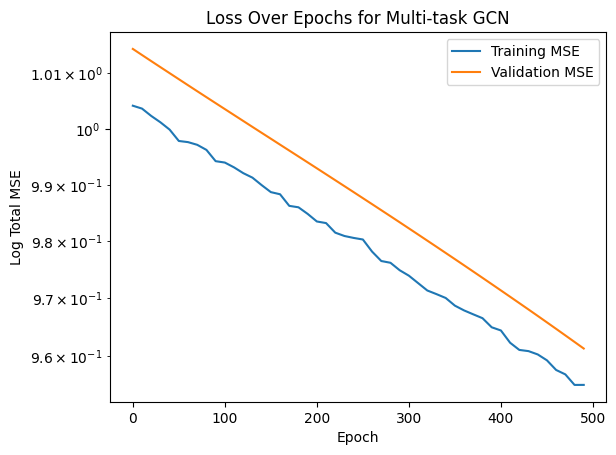

Epoch 000 | Train: 0.9966 | Val: 1.0043 * NEW BEST
Epoch 010 | Train: 0.9951 | Val: 1.0034 * NEW BEST
Epoch 020 | Train: 0.9937 | Val: 1.0025 * NEW BEST
Epoch 030 | Train: 0.9938 | Val: 1.0015 * NEW BEST
Epoch 040 | Train: 0.9919 | Val: 1.0006 * NEW BEST
Epoch 050 | Train: 0.9908 | Val: 0.9997 * NEW BEST
Epoch 060 | Train: 0.9908 | Val: 0.9988 * NEW BEST
Epoch 070 | Train: 0.9893 | Val: 0.9978 * NEW BEST
Epoch 080 | Train: 0.9891 | Val: 0.9969 * NEW BEST
Epoch 090 | Train: 0.9885 | Val: 0.9960 * NEW BEST
Epoch 100 | Train: 0.9880 | Val: 0.9951 * NEW BEST
Epoch 110 | Train: 0.9865 | Val: 0.9942 * NEW BEST
Epoch 120 | Train: 0.9854 | Val: 0.9932 * NEW BEST
Epoch 130 | Train: 0.9852 | Val: 0.9923 * NEW BEST
Epoch 140 | Train: 0.9834 | Val: 0.9914 * NEW BEST
Epoch 150 | Train: 0.9837 | Val: 0.9905 * NEW BEST
Epoch 160 | Train: 0.9819 | Val: 0.9896 * NEW BEST
Epoch 170 | Train: 0.9811 | Val: 0.9886 * NEW BEST
Epoch 180 | Train: 0.9801 | Val: 0.9877 * NEW BEST
Epoch 190 | Train: 0.9801 | Val

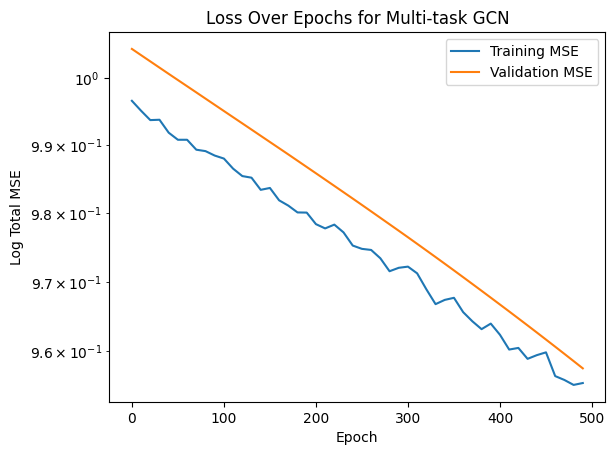

Epoch 000 | Train: 1.0044 | Val: 1.0163 * NEW BEST
Epoch 010 | Train: 1.0055 | Val: 1.0152 * NEW BEST
Epoch 020 | Train: 1.0002 | Val: 1.0142 * NEW BEST
Epoch 030 | Train: 1.0004 | Val: 1.0132 * NEW BEST
Epoch 040 | Train: 1.0003 | Val: 1.0121 * NEW BEST
Epoch 050 | Train: 1.0002 | Val: 1.0111 * NEW BEST
Epoch 060 | Train: 0.9977 | Val: 1.0101 * NEW BEST
Epoch 070 | Train: 0.9980 | Val: 1.0091 * NEW BEST
Epoch 080 | Train: 0.9981 | Val: 1.0081 * NEW BEST
Epoch 090 | Train: 0.9948 | Val: 1.0071 * NEW BEST
Epoch 100 | Train: 0.9955 | Val: 1.0061 * NEW BEST
Epoch 110 | Train: 0.9939 | Val: 1.0051 * NEW BEST
Epoch 120 | Train: 0.9925 | Val: 1.0041 * NEW BEST
Epoch 130 | Train: 0.9924 | Val: 1.0031 * NEW BEST
Epoch 140 | Train: 0.9923 | Val: 1.0021 * NEW BEST
Epoch 150 | Train: 0.9909 | Val: 1.0011 * NEW BEST
Epoch 160 | Train: 0.9883 | Val: 1.0001 * NEW BEST
Epoch 170 | Train: 0.9889 | Val: 0.9991 * NEW BEST
Epoch 180 | Train: 0.9872 | Val: 0.9982 * NEW BEST
Epoch 190 | Train: 0.9881 | Val

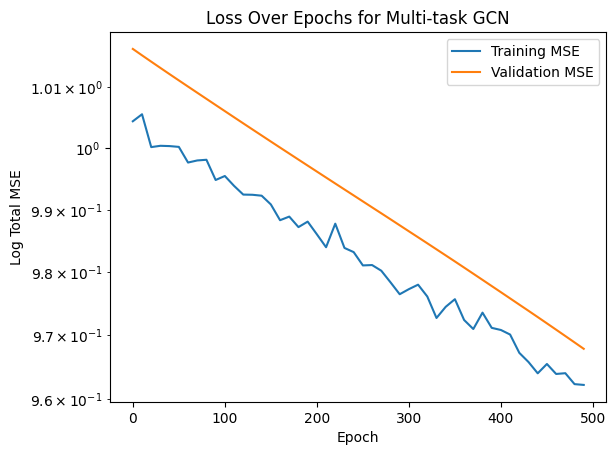

Best params: {'lr': 0.001, 'n_neurons': 128, 'dr': 0.5}
Best val loss: 0.6005294919013977


{'lr': 0.001, 'n_neurons': 128, 'dr': 0.5}

In [10]:
# hyperparameter tuning
My_Fit.hp_tuning(graph_data, X.shape[1])